In [2]:
import os
import functools
from time import perf_counter

import torch
import numpy as np
import matplotlib.pyplot as plt

import lightdde as dde

# Define PDE and exact solution

![](equations.png)

In [3]:
Re = 20
nu = 1 / Re
l = 1 / (2 * nu) - (1 / (4 * nu ** 2) + 4 * torch.pi ** 2)**0.5

In [4]:
def pde(x, u):
    u_vel, v_vel, p = u[:, 0:1], u[:, 1:2], u[:, 2:]
    u_vel_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_vel_y = dde.grad.jacobian(u, x, i=0, j=1)
    u_vel_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)
    u_vel_yy = dde.grad.hessian(u, x, component=0, i=1, j=1)

    v_vel_x = dde.grad.jacobian(u, x, i=1, j=0)
    v_vel_y = dde.grad.jacobian(u, x, i=1, j=1)
    v_vel_xx = dde.grad.hessian(u, x, component=1, i=0, j=0)
    v_vel_yy = dde.grad.hessian(u, x, component=1, i=1, j=1)

    p_x = dde.grad.jacobian(u, x, i=2, j=0)
    p_y = dde.grad.jacobian(u, x, i=2, j=1)

    momentum_x = (
        u_vel * u_vel_x + v_vel * u_vel_y + p_x - 1 / Re * (u_vel_xx + u_vel_yy)
    )
    momentum_y = (
        u_vel * v_vel_x + v_vel * v_vel_y + p_y - 1 / Re * (v_vel_xx + v_vel_yy)
    )
    continuity = u_vel_x + v_vel_y

    return [momentum_x, momentum_y, continuity]

In [5]:
def u_func(x):
    return 1 - torch.exp(l * x[:, 0:1]) * torch.cos(2 * torch.pi * x[:, 1:2])

def v_func(x):
    return l / (2 * torch.pi) * torch.exp(l * x[:, 0:1]) * torch.sin(2 * torch.pi * x[:, 1:2])

def p_func(x):
    return 1 / 2 * (1 - torch.exp(2 * l * x[:, 0:1]))

# Define geometry

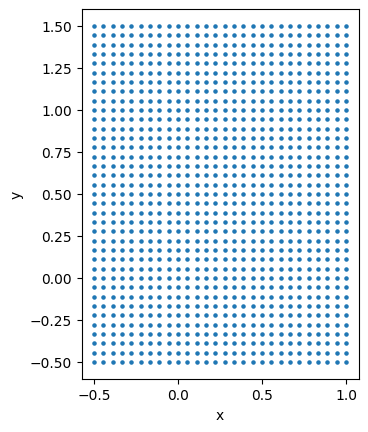

In [6]:
domain = dde.geometry.Hypercube(xmin=[-0.5, -0.5], xmax=[1., 1.5])

# visualisation
sample = domain.uniform_points(1000)
plt.figure()
plt.scatter(sample[:, 0], sample[:, 1], s=5)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Define model

In [8]:
class FNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = torch.nn.Tanh()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 50),
            self.activation,
            torch.nn.Linear(50, 50),
            self.activation,
            torch.nn.Linear(50, 50),
            self.activation,
            torch.nn.Linear(50, 50),
            self.activation,
            torch.nn.Linear(50, 3),
        )

    def forward(self, x):
        x = x.view(-1, 2)
        return self.net(x)

# test run
fnn = FNN()
out = fnn(torch.rand(3, 2))
print(out.shape)
print(out)

# summary
print("Summary:")
from torchsummary import summary
summary(fnn, input_size=(1, 2), device="cpu")

torch.Size([3, 3])
tensor([[-0.0681, -0.1795, -0.0441],
        [-0.0589, -0.1810, -0.0220],
        [-0.0917, -0.1619, -0.0718]], grad_fn=<AddmmBackward0>)
Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]             150
              Tanh-2                   [-1, 50]               0
              Tanh-3                   [-1, 50]               0
            Linear-4                   [-1, 50]           2,550
              Tanh-5                   [-1, 50]               0
              Tanh-6                   [-1, 50]               0
            Linear-7                   [-1, 50]           2,550
              Tanh-8                   [-1, 50]               0
              Tanh-9                   [-1, 50]               0
           Linear-10                   [-1, 50]           2,550
             Tanh-11                   [-1, 50]               0
 

## Define dde.Model

In [9]:
domain = dde.geometry.Hypercube(xmin=[-0.5, -0.5], xmax=[1., 1.5])

In [10]:
boundary_condition_u = dde.bc.DirichletBC(domain,
                                          u_func,
                                          lambda _, on_boundary: on_boundary,
                                          component=0)

boundary_condition_v = dde.bc.DirichletBC(domain,
                                          v_func,
                                          lambda _, on_boundary: on_boundary,
                                          component=1)

def on_boundary_p(x, on_boundary):
    return on_boundary and torch.isclose(x[0], torch.tensor(1.0))

boundary_condition_right_p = dde.bc.DirichletBC(domain,
                                                p_func,
                                                on_boundary_p,
                                                component=2)

In [11]:
data = dde.data.PDEData(
    domain=domain,
    pde=pde,
    bcs=[boundary_condition_u, boundary_condition_v, boundary_condition_right_p],
    exact_solution=[u_func, v_func, p_func],
    num_domain=2601,
    num_bc=400,
    num_test=10000,
)

## Training

In [12]:
model = dde.Model(data, FNN(), save_path="big_model", save_every=100)

In [13]:
model.compile()

Loaded snapshot at epoch 2800


In [14]:
model.train(10000)

Started training...
epoch: 2801, loss: 0.007959805428981781, metric: tensor([0.0855, 0.0321, 0.0639])
epoch: 2802, loss: 0.008255905471742153, metric: tensor([0.0814, 0.0360, 0.0642])
epoch: 2803, loss: 0.008596696890890598, metric: tensor([0.0855, 0.0321, 0.0648])
epoch: 2804, loss: 0.00853599514812231, metric: tensor([0.0829, 0.0352, 0.0634])
epoch: 2805, loss: 0.00818746630102396, metric: tensor([0.0820, 0.0328, 0.0653])
epoch: 2806, loss: 0.007939108647406101, metric: tensor([0.0858, 0.0338, 0.0643])
epoch: 2807, loss: 0.00800588633865118, metric: tensor([0.0800, 0.0341, 0.0663])
epoch: 2808, loss: 0.008217914029955864, metric: tensor([0.0867, 0.0335, 0.0641])
epoch: 2809, loss: 0.008306863717734814, metric: tensor([0.0811, 0.0346, 0.0644])
epoch: 2810, loss: 0.008165371604263783, metric: tensor([0.0848, 0.0340, 0.0630])
epoch: 2811, loss: 0.007944988086819649, metric: tensor([0.0839, 0.0339, 0.0646])
epoch: 2812, loss: 0.00787878967821598, metric: tensor([0.0809, 0.0347, 0.0641])


epoch: 2904, loss: 0.007022398989647627, metric: tensor([0.0784, 0.0324, 0.0626])
epoch: 2905, loss: 0.006977875251322985, metric: tensor([0.0798, 0.0334, 0.0618])
epoch: 2906, loss: 0.006927837152034044, metric: tensor([0.0788, 0.0326, 0.0624])
epoch: 2907, loss: 0.006881069391965866, metric: tensor([0.0793, 0.0331, 0.0619])
epoch: 2908, loss: 0.006844999268651009, metric: tensor([0.0792, 0.0328, 0.0622])
epoch: 2909, loss: 0.006822715047746897, metric: tensor([0.0787, 0.0328, 0.0621])
epoch: 2910, loss: 0.006814097054302692, metric: tensor([0.0794, 0.0330, 0.0619])
epoch: 2911, loss: 0.006816386245191097, metric: tensor([0.0783, 0.0326, 0.0622])
epoch: 2912, loss: 0.006825788877904415, metric: tensor([0.0797, 0.0331, 0.0618])
epoch: 2913, loss: 0.006838287226855755, metric: tensor([0.0780, 0.0325, 0.0623])
epoch: 2914, loss: 0.00685081584379077, metric: tensor([0.0800, 0.0332, 0.0618])
epoch: 2915, loss: 0.006860897410660982, metric: tensor([0.0778, 0.0324, 0.0624])
epoch: 2916, loss

epoch: 3004, loss: 0.0076726931147277355, metric: tensor([0.0748, 0.0302, 0.0605])
epoch: 3005, loss: 0.007576916832476854, metric: tensor([0.0773, 0.0337, 0.0587])
epoch: 3006, loss: 0.0074400207959115505, metric: tensor([0.0749, 0.0304, 0.0605])
epoch: 3007, loss: 0.007261110935360193, metric: tensor([0.0769, 0.0332, 0.0589])
epoch: 3008, loss: 0.007082425523549318, metric: tensor([0.0750, 0.0308, 0.0603])
epoch: 3009, loss: 0.006907606031745672, metric: tensor([0.0766, 0.0327, 0.0591])
epoch: 3010, loss: 0.00675901910290122, metric: tensor([0.0752, 0.0312, 0.0602])
epoch: 3011, loss: 0.006636874750256538, metric: tensor([0.0762, 0.0322, 0.0594])
epoch: 3012, loss: 0.0065455068834125996, metric: tensor([0.0754, 0.0316, 0.0602])
epoch: 3013, loss: 0.006480439566075802, metric: tensor([0.0760, 0.0318, 0.0598])
epoch: 3014, loss: 0.0064376890659332275, metric: tensor([0.0756, 0.0319, 0.0602])
epoch: 3015, loss: 0.006411654409021139, metric: tensor([0.0758, 0.0316, 0.0601])
epoch: 3016, 

epoch: 3107, loss: 0.007077320013195276, metric: tensor([0.0740, 0.0304, 0.0537])
epoch: 3108, loss: 0.006259646732360125, metric: tensor([0.0702, 0.0314, 0.0544])
epoch: 3109, loss: 0.006329922005534172, metric: tensor([0.0748, 0.0323, 0.0546])
epoch: 3110, loss: 0.006990782916545868, metric: tensor([0.0705, 0.0302, 0.0554])
epoch: 3111, loss: 0.007716554682701826, metric: tensor([0.0750, 0.0333, 0.0558])
epoch: 3112, loss: 0.00801516231149435, metric: tensor([0.0717, 0.0298, 0.0561])
epoch: 3113, loss: 0.007794564589858055, metric: tensor([0.0740, 0.0329, 0.0565])
epoch: 3114, loss: 0.007164308801293373, metric: tensor([0.0728, 0.0300, 0.0565])
epoch: 3115, loss: 0.006507059093564749, metric: tensor([0.0723, 0.0317, 0.0569])
epoch: 3116, loss: 0.006108170375227928, metric: tensor([0.0740, 0.0309, 0.0570])
epoch: 3117, loss: 0.006083456799387932, metric: tensor([0.0711, 0.0307, 0.0576])
epoch: 3118, loss: 0.006345995701849461, metric: tensor([0.0752, 0.0317, 0.0579])
epoch: 3119, loss

epoch: 3207, loss: 0.013572405092418194, metric: tensor([0.0796, 0.0275, 0.0505])
epoch: 3208, loss: 0.008999690413475037, metric: tensor([0.0701, 0.0330, 0.0505])
epoch: 3209, loss: 0.006622254848480225, metric: tensor([0.0643, 0.0314, 0.0510])
epoch: 3210, loss: 0.0070821018889546394, metric: tensor([0.0828, 0.0297, 0.0487])
epoch: 3211, loss: 0.009172007441520691, metric: tensor([0.0613, 0.0348, 0.0523])
epoch: 3212, loss: 0.010808954946696758, metric: tensor([0.0868, 0.0283, 0.0497])
epoch: 3213, loss: 0.010674185119569302, metric: tensor([0.0639, 0.0347, 0.0531])
epoch: 3214, loss: 0.008889221586287022, metric: tensor([0.0765, 0.0288, 0.0516])
epoch: 3215, loss: 0.006958760321140289, metric: tensor([0.0721, 0.0323, 0.0521])
epoch: 3216, loss: 0.006255473010241985, metric: tensor([0.0655, 0.0311, 0.0534])
epoch: 3217, loss: 0.006953640375286341, metric: tensor([0.0813, 0.0306, 0.0519])
epoch: 3218, loss: 0.008112664334475994, metric: tensor([0.0628, 0.0327, 0.0555])
epoch: 3219, lo

epoch: 3307, loss: 0.006009989883750677, metric: tensor([0.0678, 0.0302, 0.0582])
epoch: 3308, loss: 0.005762783344835043, metric: tensor([0.0745, 0.0295, 0.0579])
epoch: 3309, loss: 0.0059499433264136314, metric: tensor([0.0657, 0.0300, 0.0596])
epoch: 3310, loss: 0.006294079590588808, metric: tensor([0.0758, 0.0300, 0.0579])
epoch: 3311, loss: 0.006418013945221901, metric: tensor([0.0667, 0.0295, 0.0597])
epoch: 3312, loss: 0.0061997477896511555, metric: tensor([0.0725, 0.0303, 0.0581])
epoch: 3313, loss: 0.005820260848850012, metric: tensor([0.0701, 0.0290, 0.0587])
epoch: 3314, loss: 0.005580952391028404, metric: tensor([0.0683, 0.0305, 0.0587])
epoch: 3315, loss: 0.005626495461910963, metric: tensor([0.0735, 0.0287, 0.0577])
epoch: 3316, loss: 0.005854851100593805, metric: tensor([0.0662, 0.0306, 0.0590])
epoch: 3317, loss: 0.00604275381192565, metric: tensor([0.0739, 0.0287, 0.0572])
epoch: 3318, loss: 0.006030610296875238, metric: tensor([0.0668, 0.0305, 0.0585])
epoch: 3319, lo

epoch: 3407, loss: 0.005592542700469494, metric: tensor([0.0663, 0.0305, 0.0555])
epoch: 3408, loss: 0.00569887226447463, metric: tensor([0.0686, 0.0272, 0.0551])
epoch: 3409, loss: 0.0058414689265191555, metric: tensor([0.0661, 0.0310, 0.0554])
epoch: 3410, loss: 0.006039544474333525, metric: tensor([0.0690, 0.0268, 0.0549])
epoch: 3411, loss: 0.0063043138943612576, metric: tensor([0.0658, 0.0318, 0.0553])
epoch: 3412, loss: 0.006671704351902008, metric: tensor([0.0695, 0.0263, 0.0546])
epoch: 3413, loss: 0.007155673578381538, metric: tensor([0.0654, 0.0329, 0.0551])
epoch: 3414, loss: 0.007817676290869713, metric: tensor([0.0703, 0.0258, 0.0541])
epoch: 3415, loss: 0.008655067533254623, metric: tensor([0.0651, 0.0344, 0.0548])
epoch: 3416, loss: 0.009750058874487877, metric: tensor([0.0714, 0.0254, 0.0534])
epoch: 3417, loss: 0.011005371809005737, metric: tensor([0.0647, 0.0361, 0.0541])
epoch: 3418, loss: 0.012465390376746655, metric: tensor([0.0725, 0.0252, 0.0522])
epoch: 3419, lo

epoch: 3507, loss: 0.0050000580959022045, metric: tensor([0.0653, 0.0285, 0.0555])
epoch: 3508, loss: 0.005022392142564058, metric: tensor([0.0664, 0.0281, 0.0560])
epoch: 3509, loss: 0.0051929340697824955, metric: tensor([0.0659, 0.0284, 0.0554])
epoch: 3510, loss: 0.00539199635386467, metric: tensor([0.0663, 0.0282, 0.0562])
epoch: 3511, loss: 0.005510183051228523, metric: tensor([0.0660, 0.0283, 0.0551])
epoch: 3512, loss: 0.005503366235643625, metric: tensor([0.0660, 0.0283, 0.0558])
epoch: 3513, loss: 0.0053821736946702, metric: tensor([0.0657, 0.0281, 0.0550])
epoch: 3514, loss: 0.005212835501879454, metric: tensor([0.0657, 0.0284, 0.0553])
epoch: 3515, loss: 0.00506154028698802, metric: tensor([0.0654, 0.0279, 0.0551])
epoch: 3516, loss: 0.004979080520570278, metric: tensor([0.0656, 0.0285, 0.0550])
epoch: 3517, loss: 0.004977596923708916, metric: tensor([0.0653, 0.0277, 0.0552])
epoch: 3518, loss: 0.005035258363932371, metric: tensor([0.0655, 0.0285, 0.0545])
epoch: 3519, loss:

epoch: 3607, loss: 0.006305343005806208, metric: tensor([0.0655, 0.0296, 0.0510])
epoch: 3608, loss: 0.005860331002622843, metric: tensor([0.0628, 0.0263, 0.0523])
epoch: 3609, loss: 0.005385552067309618, metric: tensor([0.0635, 0.0285, 0.0519])
epoch: 3610, loss: 0.005022046621888876, metric: tensor([0.0643, 0.0271, 0.0525])
epoch: 3611, loss: 0.0048369006253778934, metric: tensor([0.0624, 0.0274, 0.0528])
epoch: 3612, loss: 0.004837405867874622, metric: tensor([0.0653, 0.0282, 0.0527])
epoch: 3613, loss: 0.004972632043063641, metric: tensor([0.0622, 0.0266, 0.0535])
epoch: 3614, loss: 0.005167072638869286, metric: tensor([0.0658, 0.0289, 0.0531])
epoch: 3615, loss: 0.005341607145965099, metric: tensor([0.0623, 0.0262, 0.0541])
epoch: 3616, loss: 0.005445076152682304, metric: tensor([0.0657, 0.0291, 0.0535])
epoch: 3617, loss: 0.005453488789498806, metric: tensor([0.0623, 0.0262, 0.0544])
epoch: 3618, loss: 0.005374984350055456, metric: tensor([0.0653, 0.0287, 0.0536])
epoch: 3619, lo

epoch: 3707, loss: 0.017258737236261368, metric: tensor([0.0583, 0.0250, 0.0484])
epoch: 3708, loss: 0.016038015484809875, metric: tensor([0.0625, 0.0348, 0.0465])
epoch: 3709, loss: 0.013039874844253063, metric: tensor([0.0613, 0.0241, 0.0457])
epoch: 3710, loss: 0.00928474497050047, metric: tensor([0.0565, 0.0303, 0.0455])
epoch: 3711, loss: 0.006391674745827913, metric: tensor([0.0655, 0.0259, 0.0437])
epoch: 3712, loss: 0.005381735507398844, metric: tensor([0.0529, 0.0271, 0.0456])
epoch: 3713, loss: 0.006205603946000338, metric: tensor([0.0681, 0.0295, 0.0434])
epoch: 3714, loss: 0.007787025533616543, metric: tensor([0.0532, 0.0261, 0.0463])
epoch: 3715, loss: 0.008912885561585426, metric: tensor([0.0665, 0.0309, 0.0445])
epoch: 3716, loss: 0.008688223548233509, metric: tensor([0.0567, 0.0254, 0.0466])
epoch: 3717, loss: 0.007414691150188446, metric: tensor([0.0612, 0.0295, 0.0462])
epoch: 3718, loss: 0.005853121168911457, metric: tensor([0.0627, 0.0257, 0.0464])
epoch: 3719, loss

epoch: 3807, loss: 0.006846352014690638, metric: tensor([0.0613, 0.0266, 0.0477])
epoch: 3808, loss: 0.00545880664139986, metric: tensor([0.0635, 0.0266, 0.0485])
epoch: 3809, loss: 0.00469550583511591, metric: tensor([0.0567, 0.0278, 0.0498])
epoch: 3810, loss: 0.004997005220502615, metric: tensor([0.0677, 0.0257, 0.0479])
epoch: 3811, loss: 0.0057986113242805, metric: tensor([0.0571, 0.0283, 0.0512])
epoch: 3812, loss: 0.006245912052690983, metric: tensor([0.0665, 0.0255, 0.0494])
epoch: 3813, loss: 0.00593827199190855, metric: tensor([0.0596, 0.0278, 0.0523])
epoch: 3814, loss: 0.005198200233280659, metric: tensor([0.0614, 0.0260, 0.0520])
epoch: 3815, loss: 0.004623463377356529, metric: tensor([0.0638, 0.0270, 0.0522])
epoch: 3816, loss: 0.004567970056086779, metric: tensor([0.0578, 0.0268, 0.0536])
epoch: 3817, loss: 0.004919595085084438, metric: tensor([0.0666, 0.0262, 0.0519])
epoch: 3818, loss: 0.005282239988446236, metric: tensor([0.0575, 0.0271, 0.0543])
epoch: 3819, loss: 0.

epoch: 3907, loss: 0.004270110744982958, metric: tensor([0.0575, 0.0269, 0.0516])
epoch: 3908, loss: 0.004396283999085426, metric: tensor([0.0617, 0.0246, 0.0510])
epoch: 3909, loss: 0.004550935700535774, metric: tensor([0.0568, 0.0275, 0.0515])
epoch: 3910, loss: 0.004652849864214659, metric: tensor([0.0618, 0.0244, 0.0507])
epoch: 3911, loss: 0.004652296658605337, metric: tensor([0.0566, 0.0273, 0.0513])
epoch: 3912, loss: 0.004562268033623695, metric: tensor([0.0604, 0.0247, 0.0507])
epoch: 3913, loss: 0.004420980345457792, metric: tensor([0.0574, 0.0267, 0.0511])
epoch: 3914, loss: 0.004283049143850803, metric: tensor([0.0589, 0.0253, 0.0508])
epoch: 3915, loss: 0.004188209306448698, metric: tensor([0.0590, 0.0257, 0.0507])
epoch: 3916, loss: 0.004156469367444515, metric: tensor([0.0576, 0.0260, 0.0507])
epoch: 3917, loss: 0.004180732183158398, metric: tensor([0.0603, 0.0251, 0.0503])
epoch: 3918, loss: 0.004235090222209692, metric: tensor([0.0567, 0.0264, 0.0508])
epoch: 3919, los

epoch: 4007, loss: 0.006043451372534037, metric: tensor([0.0556, 0.0266, 0.0482])
epoch: 4008, loss: 0.006431475281715393, metric: tensor([0.0629, 0.0248, 0.0463])
epoch: 4009, loss: 0.005997133441269398, metric: tensor([0.0551, 0.0262, 0.0492])
epoch: 4010, loss: 0.005075502209365368, metric: tensor([0.0607, 0.0252, 0.0478])
epoch: 4011, loss: 0.004294670186936855, metric: tensor([0.0566, 0.0255, 0.0488])
epoch: 4012, loss: 0.004075019154697657, metric: tensor([0.0575, 0.0257, 0.0494])
epoch: 4013, loss: 0.0043984465301036835, metric: tensor([0.0600, 0.0249, 0.0489])
epoch: 4014, loss: 0.004923738539218903, metric: tensor([0.0562, 0.0259, 0.0513])
epoch: 4015, loss: 0.005257536191493273, metric: tensor([0.0618, 0.0248, 0.0499])
epoch: 4016, loss: 0.00521086435765028, metric: tensor([0.0560, 0.0257, 0.0521])
epoch: 4017, loss: 0.004834761377424002, metric: tensor([0.0602, 0.0250, 0.0508])
epoch: 4018, loss: 0.004369453992694616, metric: tensor([0.0570, 0.0252, 0.0516])
epoch: 4019, los

epoch: 4107, loss: 0.00400268891826272, metric: tensor([0.0527, 0.0253, 0.0493])
epoch: 4108, loss: 0.0040915305726230145, metric: tensor([0.0587, 0.0238, 0.0486])
epoch: 4109, loss: 0.004114141687750816, metric: tensor([0.0530, 0.0255, 0.0495])
epoch: 4110, loss: 0.004053807817399502, metric: tensor([0.0576, 0.0239, 0.0488])
epoch: 4111, loss: 0.003951545804738998, metric: tensor([0.0548, 0.0249, 0.0490])
epoch: 4112, loss: 0.0038628727197647095, metric: tensor([0.0556, 0.0244, 0.0488])
epoch: 4113, loss: 0.003827272914350033, metric: tensor([0.0566, 0.0243, 0.0486])
epoch: 4114, loss: 0.0038470420986413956, metric: tensor([0.0539, 0.0249, 0.0491])
epoch: 4115, loss: 0.003896459937095642, metric: tensor([0.0576, 0.0240, 0.0488])
epoch: 4116, loss: 0.003940815106034279, metric: tensor([0.0536, 0.0251, 0.0495])
epoch: 4117, loss: 0.003952971659600735, metric: tensor([0.0576, 0.0240, 0.0490])
epoch: 4118, loss: 0.003929435275495052, metric: tensor([0.0543, 0.0248, 0.0493])
epoch: 4119, l

epoch: 4207, loss: 0.003683589631691575, metric: tensor([0.0548, 0.0239, 0.0487])
epoch: 4208, loss: 0.003676743246614933, metric: tensor([0.0547, 0.0239, 0.0487])
epoch: 4209, loss: 0.003679549554362893, metric: tensor([0.0545, 0.0240, 0.0487])
epoch: 4210, loss: 0.0036878499668091536, metric: tensor([0.0548, 0.0238, 0.0484])
epoch: 4211, loss: 0.003696669591590762, metric: tensor([0.0543, 0.0240, 0.0487])
epoch: 4212, loss: 0.0037019813898950815, metric: tensor([0.0548, 0.0238, 0.0484])
epoch: 4213, loss: 0.003701947396621108, metric: tensor([0.0543, 0.0240, 0.0487])
epoch: 4214, loss: 0.0036968369968235493, metric: tensor([0.0547, 0.0238, 0.0485])
epoch: 4215, loss: 0.0036885791923850775, metric: tensor([0.0545, 0.0240, 0.0486])
epoch: 4216, loss: 0.003679591929540038, metric: tensor([0.0543, 0.0238, 0.0485])
epoch: 4217, loss: 0.00367224239744246, metric: tensor([0.0547, 0.0240, 0.0484])
epoch: 4218, loss: 0.0036680176854133606, metric: tensor([0.0539, 0.0238, 0.0485])
epoch: 4219,

epoch: 4307, loss: 0.006682502571493387, metric: tensor([0.0676, 0.0207, 0.0446])
epoch: 4308, loss: 0.007825766690075397, metric: tensor([0.0456, 0.0288, 0.0485])
epoch: 4309, loss: 0.009250834584236145, metric: tensor([0.0738, 0.0204, 0.0433])
epoch: 4310, loss: 0.010923841036856174, metric: tensor([0.0462, 0.0304, 0.0481])
epoch: 4311, loss: 0.012530427426099777, metric: tensor([0.0783, 0.0204, 0.0417])
epoch: 4312, loss: 0.013754588551819324, metric: tensor([0.0472, 0.0312, 0.0466])
epoch: 4313, loss: 0.013899938203394413, metric: tensor([0.0758, 0.0204, 0.0404])
epoch: 4314, loss: 0.012682958506047726, metric: tensor([0.0468, 0.0297, 0.0442])
epoch: 4315, loss: 0.010148831643164158, metric: tensor([0.0641, 0.0211, 0.0400])
epoch: 4316, loss: 0.007102614268660545, metric: tensor([0.0487, 0.0262, 0.0416])
epoch: 4317, loss: 0.004720256198197603, metric: tensor([0.0510, 0.0238, 0.0405])
epoch: 4318, loss: 0.0037657469511032104, metric: tensor([0.0565, 0.0229, 0.0400])
epoch: 4319, lo

epoch: 4407, loss: 0.0034198539797216654, metric: tensor([0.0516, 0.0228, 0.0469])
epoch: 4408, loss: 0.0034046312794089317, metric: tensor([0.0519, 0.0227, 0.0469])
epoch: 4409, loss: 0.0033941904548555613, metric: tensor([0.0516, 0.0229, 0.0469])
epoch: 4410, loss: 0.0033886325545608997, metric: tensor([0.0518, 0.0226, 0.0469])
epoch: 4411, loss: 0.0033872632775455713, metric: tensor([0.0516, 0.0230, 0.0469])
epoch: 4412, loss: 0.0033890288323163986, metric: tensor([0.0518, 0.0226, 0.0469])
epoch: 4413, loss: 0.0033927038311958313, metric: tensor([0.0516, 0.0230, 0.0469])
epoch: 4414, loss: 0.003397232387214899, metric: tensor([0.0517, 0.0225, 0.0468])
epoch: 4415, loss: 0.0034017895814031363, metric: tensor([0.0515, 0.0231, 0.0469])
epoch: 4416, loss: 0.003405819647014141, metric: tensor([0.0518, 0.0225, 0.0467])
epoch: 4417, loss: 0.0034091374836862087, metric: tensor([0.0514, 0.0231, 0.0469])
epoch: 4418, loss: 0.0034116972237825394, metric: tensor([0.0519, 0.0224, 0.0467])
epoch:

epoch: 4507, loss: 0.007400611415505409, metric: tensor([0.0566, 0.0228, 0.0378])
epoch: 4508, loss: 0.006751872133463621, metric: tensor([0.0488, 0.0223, 0.0420])
epoch: 4509, loss: 0.004865314811468124, metric: tensor([0.0490, 0.0240, 0.0416])
epoch: 4510, loss: 0.003674271982163191, metric: tensor([0.0552, 0.0215, 0.0410])
epoch: 4511, loss: 0.00402037100866437, metric: tensor([0.0468, 0.0244, 0.0439])
epoch: 4512, loss: 0.005128193646669388, metric: tensor([0.0583, 0.0216, 0.0410])
epoch: 4513, loss: 0.005659524351358414, metric: tensor([0.0480, 0.0235, 0.0450])
epoch: 4514, loss: 0.0050986213609576225, metric: tensor([0.0536, 0.0225, 0.0440])
epoch: 4515, loss: 0.004028547555208206, metric: tensor([0.0519, 0.0222, 0.0455])
epoch: 4516, loss: 0.0033910705242305994, metric: tensor([0.0484, 0.0236, 0.0468])
epoch: 4517, loss: 0.003586712060496211, metric: tensor([0.0567, 0.0215, 0.0454])
epoch: 4518, loss: 0.004238244611769915, metric: tensor([0.0474, 0.0239, 0.0480])
epoch: 4519, lo

epoch: 4607, loss: 0.0037828346248716116, metric: tensor([0.0541, 0.0222, 0.0453])
epoch: 4608, loss: 0.0038345721550285816, metric: tensor([0.0460, 0.0216, 0.0464])
epoch: 4609, loss: 0.003667920595034957, metric: tensor([0.0519, 0.0221, 0.0457])
epoch: 4610, loss: 0.0033962964080274105, metric: tensor([0.0483, 0.0216, 0.0460])
epoch: 4611, loss: 0.00318508711643517, metric: tensor([0.0484, 0.0218, 0.0460])
epoch: 4612, loss: 0.0031308885663747787, metric: tensor([0.0511, 0.0218, 0.0454])
epoch: 4613, loss: 0.003219631500542164, metric: tensor([0.0464, 0.0217, 0.0461])
epoch: 4614, loss: 0.003356487490236759, metric: tensor([0.0524, 0.0218, 0.0453])
epoch: 4615, loss: 0.0034404341131448746, metric: tensor([0.0462, 0.0217, 0.0460])
epoch: 4616, loss: 0.0034236887004226446, metric: tensor([0.0514, 0.0217, 0.0453])
epoch: 4617, loss: 0.0033252404537051916, metric: tensor([0.0473, 0.0217, 0.0456])
epoch: 4618, loss: 0.003209102200344205, metric: tensor([0.0493, 0.0215, 0.0452])
epoch: 461

epoch: 4707, loss: 0.007089666090905666, metric: tensor([0.0452, 0.0218, 0.0453])
epoch: 4708, loss: 0.00883291382342577, metric: tensor([0.0621, 0.0206, 0.0404])
epoch: 4709, loss: 0.011102362535893917, metric: tensor([0.0474, 0.0223, 0.0451])
epoch: 4710, loss: 0.013674095273017883, metric: tensor([0.0673, 0.0202, 0.0385])
epoch: 4711, loss: 0.01609913632273674, metric: tensor([0.0494, 0.0228, 0.0441])
epoch: 4712, loss: 0.017296846956014633, metric: tensor([0.0669, 0.0201, 0.0365])
epoch: 4713, loss: 0.01633758470416069, metric: tensor([0.0469, 0.0228, 0.0416])
epoch: 4714, loss: 0.0127381831407547, metric: tensor([0.0563, 0.0205, 0.0356])
epoch: 4715, loss: 0.007884243503212929, metric: tensor([0.0442, 0.0223, 0.0378])
epoch: 4716, loss: 0.0040952106937766075, metric: tensor([0.0450, 0.0215, 0.0364])
epoch: 4717, loss: 0.0031799334101378918, metric: tensor([0.0517, 0.0214, 0.0349])
epoch: 4718, loss: 0.0048922388814389706, metric: tensor([0.0444, 0.0225, 0.0383])
epoch: 4719, loss:

epoch: 4807, loss: 0.0224923025816679, metric: tensor([0.0436, 0.0322, 0.0347])
epoch: 4808, loss: 0.01677864044904709, metric: tensor([0.0462, 0.0188, 0.0327])
epoch: 4809, loss: 0.008737162686884403, metric: tensor([0.0410, 0.0227, 0.0322])
epoch: 4810, loss: 0.003679286688566208, metric: tensor([0.0407, 0.0232, 0.0314])
epoch: 4811, loss: 0.00393831729888916, metric: tensor([0.0431, 0.0191, 0.0315])
epoch: 4812, loss: 0.007770790718495846, metric: tensor([0.0412, 0.0296, 0.0315])
epoch: 4813, loss: 0.011203396134078503, metric: tensor([0.0461, 0.0194, 0.0321])
epoch: 4814, loss: 0.010812745429575443, metric: tensor([0.0431, 0.0267, 0.0324])
epoch: 4815, loss: 0.007463419809937477, metric: tensor([0.0446, 0.0196, 0.0326])
epoch: 4816, loss: 0.003953178878873587, metric: tensor([0.0431, 0.0205, 0.0328])
epoch: 4817, loss: 0.003186886664479971, metric: tensor([0.0422, 0.0247, 0.0331])
epoch: 4818, loss: 0.0050467923283576965, metric: tensor([0.0449, 0.0189, 0.0346])
epoch: 4819, loss: 

epoch: 4907, loss: 0.002921708393841982, metric: tensor([0.0453, 0.0198, 0.0429])
epoch: 4908, loss: 0.0029085581190884113, metric: tensor([0.0464, 0.0209, 0.0434])
epoch: 4909, loss: 0.0032133334316313267, metric: tensor([0.0445, 0.0200, 0.0435])
epoch: 4910, loss: 0.0035542715340852737, metric: tensor([0.0472, 0.0206, 0.0443])
epoch: 4911, loss: 0.003682241775095463, metric: tensor([0.0451, 0.0202, 0.0439])
epoch: 4912, loss: 0.0035482714883983135, metric: tensor([0.0461, 0.0202, 0.0443])
epoch: 4913, loss: 0.0032474189065396786, metric: tensor([0.0461, 0.0203, 0.0434])
epoch: 4914, loss: 0.0029715097043663263, metric: tensor([0.0441, 0.0200, 0.0437])
epoch: 4915, loss: 0.002854763064533472, metric: tensor([0.0473, 0.0204, 0.0430])
epoch: 4916, loss: 0.002918359125033021, metric: tensor([0.0428, 0.0199, 0.0435])
epoch: 4917, loss: 0.003076494438573718, metric: tensor([0.0482, 0.0204, 0.0431])
epoch: 4918, loss: 0.003207192523404956, metric: tensor([0.0423, 0.0201, 0.0434])
epoch: 491

epoch: 5007, loss: 0.002695293165743351, metric: tensor([0.0429, 0.0198, 0.0419])
epoch: 5008, loss: 0.0026993181090801954, metric: tensor([0.0452, 0.0196, 0.0414])
epoch: 5009, loss: 0.0027040373533964157, metric: tensor([0.0428, 0.0197, 0.0419])
epoch: 5010, loss: 0.0027098634745925665, metric: tensor([0.0453, 0.0196, 0.0413])
epoch: 5011, loss: 0.002717128721997142, metric: tensor([0.0426, 0.0197, 0.0419])
epoch: 5012, loss: 0.0027265248354524374, metric: tensor([0.0454, 0.0195, 0.0412])
epoch: 5013, loss: 0.0027387237641960382, metric: tensor([0.0424, 0.0197, 0.0419])
epoch: 5014, loss: 0.0027549227233976126, metric: tensor([0.0457, 0.0196, 0.0411])
epoch: 5015, loss: 0.0027764481492340565, metric: tensor([0.0420, 0.0197, 0.0419])
epoch: 5016, loss: 0.0028055564034730196, metric: tensor([0.0462, 0.0196, 0.0409])
epoch: 5017, loss: 0.002844899659976363, metric: tensor([0.0416, 0.0196, 0.0419])
epoch: 5018, loss: 0.0028989408165216446, metric: tensor([0.0468, 0.0196, 0.0407])
epoch: 

epoch: 5107, loss: 0.004283782094717026, metric: tensor([0.0405, 0.0218, 0.0366])
epoch: 5108, loss: 0.0034387786872684956, metric: tensor([0.0419, 0.0187, 0.0368])
epoch: 5109, loss: 0.002857729559764266, metric: tensor([0.0436, 0.0196, 0.0373])
epoch: 5110, loss: 0.0026934409979730844, metric: tensor([0.0393, 0.0204, 0.0382])
epoch: 5111, loss: 0.002901385072618723, metric: tensor([0.0469, 0.0181, 0.0378])
epoch: 5112, loss: 0.0033184518106281757, metric: tensor([0.0383, 0.0217, 0.0391])
epoch: 5113, loss: 0.0037374994717538357, metric: tensor([0.0484, 0.0175, 0.0383])
epoch: 5114, loss: 0.004007965791970491, metric: tensor([0.0383, 0.0219, 0.0398])
epoch: 5115, loss: 0.004046853631734848, metric: tensor([0.0479, 0.0176, 0.0390])
epoch: 5116, loss: 0.003873906098306179, metric: tensor([0.0389, 0.0212, 0.0402])
epoch: 5117, loss: 0.00356258824467659, metric: tensor([0.0461, 0.0181, 0.0396])
epoch: 5118, loss: 0.0032257805578410625, metric: tensor([0.0401, 0.0200, 0.0403])
epoch: 5119,

epoch: 5207, loss: 0.0029564162250608206, metric: tensor([0.0435, 0.0187, 0.0339])
epoch: 5208, loss: 0.003091833321377635, metric: tensor([0.0373, 0.0191, 0.0343])
epoch: 5209, loss: 0.003621169598773122, metric: tensor([0.0433, 0.0199, 0.0350])
epoch: 5210, loss: 0.004236486740410328, metric: tensor([0.0386, 0.0185, 0.0348])
epoch: 5211, loss: 0.004697775933891535, metric: tensor([0.0431, 0.0204, 0.0360])
epoch: 5212, loss: 0.004784739576280117, metric: tensor([0.0395, 0.0184, 0.0355])
epoch: 5213, loss: 0.004552470985800028, metric: tensor([0.0425, 0.0199, 0.0366])
epoch: 5214, loss: 0.004036454018205404, metric: tensor([0.0400, 0.0186, 0.0362])
epoch: 5215, loss: 0.0034660161472857, metric: tensor([0.0417, 0.0190, 0.0371])
epoch: 5216, loss: 0.0029808718245476484, metric: tensor([0.0406, 0.0192, 0.0370])
epoch: 5217, loss: 0.0027071686927229166, metric: tensor([0.0411, 0.0181, 0.0377])
epoch: 5218, loss: 0.00266869249753654, metric: tensor([0.0413, 0.0201, 0.0378])
epoch: 5219, los

epoch: 5307, loss: 0.003080429509282112, metric: tensor([0.0467, 0.0177, 0.0388])
epoch: 5308, loss: 0.0029602106660604477, metric: tensor([0.0370, 0.0190, 0.0400])
epoch: 5309, loss: 0.0027747158892452717, metric: tensor([0.0443, 0.0178, 0.0390])
epoch: 5310, loss: 0.00259105465374887, metric: tensor([0.0387, 0.0186, 0.0398])
epoch: 5311, loss: 0.002446560189127922, metric: tensor([0.0415, 0.0181, 0.0393])
epoch: 5312, loss: 0.0023684208281338215, metric: tensor([0.0409, 0.0182, 0.0395])
epoch: 5313, loss: 0.00235777348279953, metric: tensor([0.0393, 0.0184, 0.0397])
epoch: 5314, loss: 0.00239876308478415, metric: tensor([0.0428, 0.0179, 0.0393])
epoch: 5315, loss: 0.00246642529964447, metric: tensor([0.0379, 0.0187, 0.0399])
epoch: 5316, loss: 0.0025339105632156134, metric: tensor([0.0439, 0.0178, 0.0391])
epoch: 5317, loss: 0.0025834832340478897, metric: tensor([0.0374, 0.0187, 0.0399])
epoch: 5318, loss: 0.002601011423394084, metric: tensor([0.0439, 0.0178, 0.0390])
epoch: 5319, lo

epoch: 5407, loss: 0.013520793989300728, metric: tensor([0.0406, 0.0177, 0.0378])
epoch: 5408, loss: 0.013815032318234444, metric: tensor([0.0580, 0.0182, 0.0308])
epoch: 5409, loss: 0.012499486096203327, metric: tensor([0.0374, 0.0176, 0.0354])
epoch: 5410, loss: 0.009496507234871387, metric: tensor([0.0481, 0.0184, 0.0303])
epoch: 5411, loss: 0.005928546190261841, metric: tensor([0.0348, 0.0174, 0.0324])
epoch: 5412, loss: 0.00322573515586555, metric: tensor([0.0374, 0.0184, 0.0312])
epoch: 5413, loss: 0.002424048027023673, metric: tensor([0.0418, 0.0175, 0.0302])
epoch: 5414, loss: 0.003389562712982297, metric: tensor([0.0356, 0.0182, 0.0330])
epoch: 5415, loss: 0.005051391199231148, metric: tensor([0.0490, 0.0179, 0.0300])
epoch: 5416, loss: 0.006172992289066315, metric: tensor([0.0359, 0.0180, 0.0343])
epoch: 5417, loss: 0.006050228141248226, metric: tensor([0.0472, 0.0184, 0.0312])
epoch: 5418, loss: 0.004876714199781418, metric: tensor([0.0352, 0.0176, 0.0341])
epoch: 5419, loss

epoch: 5507, loss: 0.0022829617373645306, metric: tensor([0.0394, 0.0174, 0.0373])
epoch: 5508, loss: 0.002226700074970722, metric: tensor([0.0377, 0.0169, 0.0374])
epoch: 5509, loss: 0.0022078317124396563, metric: tensor([0.0377, 0.0176, 0.0374])
epoch: 5510, loss: 0.002220713999122381, metric: tensor([0.0391, 0.0167, 0.0372])
epoch: 5511, loss: 0.0022500616032630205, metric: tensor([0.0366, 0.0178, 0.0375])
epoch: 5512, loss: 0.0022786858025938272, metric: tensor([0.0398, 0.0167, 0.0371])
epoch: 5513, loss: 0.0022936316672712564, metric: tensor([0.0363, 0.0178, 0.0375])
epoch: 5514, loss: 0.0022889890242367983, metric: tensor([0.0398, 0.0167, 0.0370])
epoch: 5515, loss: 0.002267757896333933, metric: tensor([0.0366, 0.0176, 0.0374])
epoch: 5516, loss: 0.0022364358883351088, metric: tensor([0.0390, 0.0169, 0.0371])
epoch: 5517, loss: 0.0022046242374926805, metric: tensor([0.0374, 0.0174, 0.0373])
epoch: 5518, loss: 0.002179570496082306, metric: tensor([0.0380, 0.0171, 0.0373])
epoch: 5

epoch: 5607, loss: 0.0028673449996858835, metric: tensor([0.0352, 0.0179, 0.0345])
epoch: 5608, loss: 0.002491516526788473, metric: tensor([0.0388, 0.0163, 0.0345])
epoch: 5609, loss: 0.0022938773036003113, metric: tensor([0.0341, 0.0169, 0.0353])
epoch: 5610, loss: 0.0022822062019258738, metric: tensor([0.0400, 0.0173, 0.0349])
epoch: 5611, loss: 0.002407406223937869, metric: tensor([0.0339, 0.0162, 0.0359])
epoch: 5612, loss: 0.0025910085532814264, metric: tensor([0.0400, 0.0181, 0.0354])
epoch: 5613, loss: 0.0027528770733624697, metric: tensor([0.0345, 0.0159, 0.0362])
epoch: 5614, loss: 0.002845189068466425, metric: tensor([0.0390, 0.0184, 0.0358])
epoch: 5615, loss: 0.0028514352161437273, metric: tensor([0.0356, 0.0156, 0.0364])
epoch: 5616, loss: 0.0027825133875012398, metric: tensor([0.0374, 0.0183, 0.0363])
epoch: 5617, loss: 0.0026739626191556454, metric: tensor([0.0371, 0.0156, 0.0364])
epoch: 5618, loss: 0.002549705794081092, metric: tensor([0.0357, 0.0179, 0.0366])
epoch: 5

epoch: 5707, loss: 0.006229581777006388, metric: tensor([0.0327, 0.0153, 0.0328])
epoch: 5708, loss: 0.005613283254206181, metric: tensor([0.0365, 0.0204, 0.0318])
epoch: 5709, loss: 0.004863644950091839, metric: tensor([0.0348, 0.0149, 0.0318])
epoch: 5710, loss: 0.00401010736823082, metric: tensor([0.0334, 0.0189, 0.0316])
epoch: 5711, loss: 0.0032593323849141598, metric: tensor([0.0368, 0.0151, 0.0311])
epoch: 5712, loss: 0.002661345526576042, metric: tensor([0.0319, 0.0173, 0.0318])
epoch: 5713, loss: 0.002299441024661064, metric: tensor([0.0377, 0.0160, 0.0312])
epoch: 5714, loss: 0.0021726384293287992, metric: tensor([0.0320, 0.0161, 0.0323])
epoch: 5715, loss: 0.0022415725979954004, metric: tensor([0.0374, 0.0173, 0.0319])
epoch: 5716, loss: 0.002442635130137205, metric: tensor([0.0333, 0.0154, 0.0329])
epoch: 5717, loss: 0.002704497193917632, metric: tensor([0.0364, 0.0183, 0.0328])
epoch: 5718, loss: 0.0029660011641681194, metric: tensor([0.0349, 0.0150, 0.0335])
epoch: 5719, 

epoch: 5807, loss: 0.001986319664865732, metric: tensor([0.0357, 0.0155, 0.0346])
epoch: 5808, loss: 0.0019688340835273266, metric: tensor([0.0340, 0.0162, 0.0349])
epoch: 5809, loss: 0.0019684939179569483, metric: tensor([0.0352, 0.0153, 0.0346])
epoch: 5810, loss: 0.001985253533348441, metric: tensor([0.0343, 0.0164, 0.0348])
epoch: 5811, loss: 0.002017325721681118, metric: tensor([0.0349, 0.0152, 0.0347])
epoch: 5812, loss: 0.0020622515585273504, metric: tensor([0.0345, 0.0166, 0.0347])
epoch: 5813, loss: 0.0021211584098637104, metric: tensor([0.0348, 0.0150, 0.0347])
epoch: 5814, loss: 0.002195940352976322, metric: tensor([0.0343, 0.0170, 0.0347])
epoch: 5815, loss: 0.0022989888675510883, metric: tensor([0.0351, 0.0147, 0.0345])
epoch: 5816, loss: 0.002441458171233535, metric: tensor([0.0339, 0.0177, 0.0346])
epoch: 5817, loss: 0.002657239092513919, metric: tensor([0.0358, 0.0144, 0.0342])
epoch: 5818, loss: 0.002972241025418043, metric: tensor([0.0333, 0.0189, 0.0346])
epoch: 5819

epoch: 5907, loss: 0.002096849959343672, metric: tensor([0.0390, 0.0156, 0.0271])
epoch: 5908, loss: 0.0032251698430627584, metric: tensor([0.0259, 0.0170, 0.0287])
epoch: 5909, loss: 0.004784023854881525, metric: tensor([0.0471, 0.0156, 0.0270])
epoch: 5910, loss: 0.005697529297322035, metric: tensor([0.0259, 0.0172, 0.0296])
epoch: 5911, loss: 0.005284041166305542, metric: tensor([0.0434, 0.0154, 0.0279])
epoch: 5912, loss: 0.003997968044131994, metric: tensor([0.0287, 0.0163, 0.0295])
epoch: 5913, loss: 0.002588891191408038, metric: tensor([0.0336, 0.0155, 0.0294])
epoch: 5914, loss: 0.0019005381036549807, metric: tensor([0.0369, 0.0156, 0.0295])
epoch: 5915, loss: 0.002122968900948763, metric: tensor([0.0281, 0.0162, 0.0314])
epoch: 5916, loss: 0.0028654849156737328, metric: tensor([0.0433, 0.0156, 0.0304])
epoch: 5917, loss: 0.003531546099111438, metric: tensor([0.0276, 0.0164, 0.0330])
epoch: 5918, loss: 0.0036551719531416893, metric: tensor([0.0422, 0.0155, 0.0317])
epoch: 5919,

epoch: 6007, loss: 0.0018216042080894113, metric: tensor([0.0326, 0.0145, 0.0331])
epoch: 6008, loss: 0.001834368915297091, metric: tensor([0.0327, 0.0155, 0.0331])
epoch: 6009, loss: 0.0018530634697526693, metric: tensor([0.0328, 0.0144, 0.0330])
epoch: 6010, loss: 0.0018794093048200011, metric: tensor([0.0324, 0.0157, 0.0331])
epoch: 6011, loss: 0.0019169333390891552, metric: tensor([0.0330, 0.0142, 0.0329])
epoch: 6012, loss: 0.001969356555491686, metric: tensor([0.0322, 0.0160, 0.0330])
epoch: 6013, loss: 0.0020446558482944965, metric: tensor([0.0332, 0.0140, 0.0327])
epoch: 6014, loss: 0.0021503877360373735, metric: tensor([0.0320, 0.0165, 0.0329])
epoch: 6015, loss: 0.002304500201717019, metric: tensor([0.0335, 0.0138, 0.0325])
epoch: 6016, loss: 0.0025213249027729034, metric: tensor([0.0318, 0.0173, 0.0328])
epoch: 6017, loss: 0.0028411028906702995, metric: tensor([0.0340, 0.0136, 0.0323])
epoch: 6018, loss: 0.003286841558292508, metric: tensor([0.0316, 0.0187, 0.0327])
epoch: 6

epoch: 6107, loss: 0.0017977572279050946, metric: tensor([0.0304, 0.0151, 0.0329])
epoch: 6108, loss: 0.001807513297535479, metric: tensor([0.0338, 0.0140, 0.0323])
epoch: 6109, loss: 0.0018562108743935823, metric: tensor([0.0296, 0.0151, 0.0330])
epoch: 6110, loss: 0.0019152952590957284, metric: tensor([0.0347, 0.0140, 0.0320])
epoch: 6111, loss: 0.0019584032706916332, metric: tensor([0.0293, 0.0150, 0.0330])
epoch: 6112, loss: 0.001971136312931776, metric: tensor([0.0347, 0.0141, 0.0318])
epoch: 6113, loss: 0.0019500445341691375, metric: tensor([0.0293, 0.0148, 0.0327])
epoch: 6114, loss: 0.001904505304992199, metric: tensor([0.0340, 0.0143, 0.0318])
epoch: 6115, loss: 0.0018477188423275948, metric: tensor([0.0297, 0.0145, 0.0325])
epoch: 6116, loss: 0.0017949712928384542, metric: tensor([0.0331, 0.0145, 0.0319])
epoch: 6117, loss: 0.0017568435287103057, metric: tensor([0.0303, 0.0144, 0.0322])
epoch: 6118, loss: 0.001738511142320931, metric: tensor([0.0324, 0.0146, 0.0319])
epoch: 6

epoch: 6207, loss: 0.019246794283390045, metric: tensor([0.0393, 0.0201, 0.0225])
epoch: 6208, loss: 0.01246175542473793, metric: tensor([0.0260, 0.0135, 0.0236])
epoch: 6209, loss: 0.005036085844039917, metric: tensor([0.0275, 0.0141, 0.0229])
epoch: 6210, loss: 0.0018705867696553469, metric: tensor([0.0288, 0.0166, 0.0224])
epoch: 6211, loss: 0.003914765082299709, metric: tensor([0.0268, 0.0143, 0.0237])
epoch: 6212, loss: 0.008020211942493916, metric: tensor([0.0348, 0.0200, 0.0221])
epoch: 6213, loss: 0.010207048617303371, metric: tensor([0.0279, 0.0146, 0.0240])
epoch: 6214, loss: 0.008206372149288654, metric: tensor([0.0319, 0.0169, 0.0229])
epoch: 6215, loss: 0.004375557415187359, metric: tensor([0.0270, 0.0140, 0.0236])
epoch: 6216, loss: 0.001932579674758017, metric: tensor([0.0279, 0.0137, 0.0238])
epoch: 6217, loss: 0.0025424030609428883, metric: tensor([0.0310, 0.0172, 0.0236])
epoch: 6218, loss: 0.004843517672270536, metric: tensor([0.0287, 0.0139, 0.0258])
epoch: 6219, lo

epoch: 6307, loss: 0.002504577161744237, metric: tensor([0.0291, 0.0145, 0.0326])
epoch: 6308, loss: 0.002471564570441842, metric: tensor([0.0313, 0.0133, 0.0316])
epoch: 6309, loss: 0.002156025031581521, metric: tensor([0.0312, 0.0144, 0.0319])
epoch: 6310, loss: 0.001840702723711729, metric: tensor([0.0281, 0.0135, 0.0325])
epoch: 6311, loss: 0.0017730011604726315, metric: tensor([0.0339, 0.0139, 0.0316])
epoch: 6312, loss: 0.0019381600432097912, metric: tensor([0.0276, 0.0139, 0.0325])
epoch: 6313, loss: 0.0021223840303719044, metric: tensor([0.0337, 0.0135, 0.0309])
epoch: 6314, loss: 0.0021256152540445328, metric: tensor([0.0280, 0.0140, 0.0317])
epoch: 6315, loss: 0.0019367241766303778, metric: tensor([0.0308, 0.0133, 0.0310])
epoch: 6316, loss: 0.0017112065106630325, metric: tensor([0.0301, 0.0139, 0.0313])
epoch: 6317, loss: 0.001617814996279776, metric: tensor([0.0283, 0.0135, 0.0314])
epoch: 6318, loss: 0.001692874007858336, metric: tensor([0.0325, 0.0137, 0.0305])
epoch: 631

epoch: 6407, loss: 0.002478577895089984, metric: tensor([0.0229, 0.0158, 0.0239])
epoch: 6408, loss: 0.004538288339972496, metric: tensor([0.0465, 0.0136, 0.0223])
epoch: 6409, loss: 0.006114506162703037, metric: tensor([0.0237, 0.0164, 0.0249])
epoch: 6410, loss: 0.00579735217615962, metric: tensor([0.0425, 0.0133, 0.0230])
epoch: 6411, loss: 0.004195890389382839, metric: tensor([0.0239, 0.0148, 0.0249])
epoch: 6412, loss: 0.0023346683010458946, metric: tensor([0.0289, 0.0137, 0.0246])
epoch: 6413, loss: 0.0015666859690099955, metric: tensor([0.0336, 0.0136, 0.0249])
epoch: 6414, loss: 0.0020941325929015875, metric: tensor([0.0233, 0.0150, 0.0271])
epoch: 6415, loss: 0.003173316363245249, metric: tensor([0.0415, 0.0135, 0.0261])
epoch: 6416, loss: 0.003882668912410736, metric: tensor([0.0236, 0.0151, 0.0287])
epoch: 6417, loss: 0.003626906080171466, metric: tensor([0.0382, 0.0134, 0.0274])
epoch: 6418, loss: 0.0027616163715720177, metric: tensor([0.0264, 0.0141, 0.0289])
epoch: 6419, 

epoch: 6507, loss: 0.0020613877568393946, metric: tensor([0.0288, 0.0141, 0.0294])
epoch: 6508, loss: 0.0018393427599221468, metric: tensor([0.0276, 0.0124, 0.0288])
epoch: 6509, loss: 0.0016083531081676483, metric: tensor([0.0259, 0.0132, 0.0287])
epoch: 6510, loss: 0.0015161304036155343, metric: tensor([0.0298, 0.0129, 0.0282])
epoch: 6511, loss: 0.0015817390521988273, metric: tensor([0.0248, 0.0127, 0.0292])
epoch: 6512, loss: 0.0017156426329165697, metric: tensor([0.0310, 0.0133, 0.0285])
epoch: 6513, loss: 0.0017973830690607429, metric: tensor([0.0249, 0.0125, 0.0292])
epoch: 6514, loss: 0.0017652950482442975, metric: tensor([0.0297, 0.0131, 0.0281])
epoch: 6515, loss: 0.0016489502741023898, metric: tensor([0.0261, 0.0127, 0.0284])
epoch: 6516, loss: 0.001531845424324274, metric: tensor([0.0275, 0.0127, 0.0281])
epoch: 6517, loss: 0.0014825784601271152, metric: tensor([0.0282, 0.0131, 0.0283])
epoch: 6518, loss: 0.0015144634526222944, metric: tensor([0.0263, 0.0125, 0.0288])
epoch

epoch: 6607, loss: 0.0014020069502294064, metric: tensor([0.0269, 0.0125, 0.0282])
epoch: 6608, loss: 0.0014008042635396123, metric: tensor([0.0274, 0.0126, 0.0281])
epoch: 6609, loss: 0.0014008295256644487, metric: tensor([0.0267, 0.0125, 0.0281])
epoch: 6610, loss: 0.001401596935465932, metric: tensor([0.0274, 0.0126, 0.0280])
epoch: 6611, loss: 0.0014027220895513892, metric: tensor([0.0265, 0.0125, 0.0281])
epoch: 6612, loss: 0.0014039071975275874, metric: tensor([0.0275, 0.0125, 0.0280])
epoch: 6613, loss: 0.0014049980090931058, metric: tensor([0.0265, 0.0125, 0.0280])
epoch: 6614, loss: 0.001405932242050767, metric: tensor([0.0275, 0.0125, 0.0279])
epoch: 6615, loss: 0.0014066905714571476, metric: tensor([0.0265, 0.0125, 0.0280])
epoch: 6616, loss: 0.0014073317870497704, metric: tensor([0.0274, 0.0125, 0.0279])
epoch: 6617, loss: 0.0014079100219532847, metric: tensor([0.0264, 0.0125, 0.0280])
epoch: 6618, loss: 0.0014084785943850875, metric: tensor([0.0274, 0.0125, 0.0279])
epoch:

epoch: 6707, loss: 0.019893096759915352, metric: tensor([0.0373, 0.0164, 0.0206])
epoch: 6708, loss: 0.017339978367090225, metric: tensor([0.0292, 0.0212, 0.0216])
epoch: 6709, loss: 0.012495605275034904, metric: tensor([0.0405, 0.0116, 0.0191])
epoch: 6710, loss: 0.0075253513641655445, metric: tensor([0.0266, 0.0140, 0.0212])
epoch: 6711, loss: 0.00548185408115387, metric: tensor([0.0416, 0.0153, 0.0192])
epoch: 6712, loss: 0.006902987137436867, metric: tensor([0.0268, 0.0137, 0.0215])
epoch: 6713, loss: 0.009760236367583275, metric: tensor([0.0392, 0.0197, 0.0195])
epoch: 6714, loss: 0.011058533564209938, metric: tensor([0.0242, 0.0137, 0.0213])
epoch: 6715, loss: 0.008899420499801636, metric: tensor([0.0293, 0.0168, 0.0198])
epoch: 6716, loss: 0.004982178099453449, metric: tensor([0.0248, 0.0120, 0.0203])
epoch: 6717, loss: 0.002029141178354621, metric: tensor([0.0216, 0.0127, 0.0204])
epoch: 6718, loss: 0.0019705931190401316, metric: tensor([0.0314, 0.0157, 0.0197])
epoch: 6719, lo

epoch: 6807, loss: 0.0020655717235058546, metric: tensor([0.0260, 0.0124, 0.0240])
epoch: 6808, loss: 0.001448107068426907, metric: tensor([0.0251, 0.0134, 0.0254])
epoch: 6809, loss: 0.0022836318239569664, metric: tensor([0.0343, 0.0119, 0.0234])
epoch: 6810, loss: 0.0034033465199172497, metric: tensor([0.0258, 0.0132, 0.0273])
epoch: 6811, loss: 0.0036366113927215338, metric: tensor([0.0341, 0.0121, 0.0256])
epoch: 6812, loss: 0.0028504112269729376, metric: tensor([0.0256, 0.0124, 0.0280])
epoch: 6813, loss: 0.0018195180455222726, metric: tensor([0.0271, 0.0128, 0.0283])
epoch: 6814, loss: 0.0013764974428340793, metric: tensor([0.0297, 0.0118, 0.0275])
epoch: 6815, loss: 0.0016976314364001155, metric: tensor([0.0248, 0.0131, 0.0295])
epoch: 6816, loss: 0.002308497903868556, metric: tensor([0.0324, 0.0117, 0.0279])
epoch: 6817, loss: 0.0026113451458513737, metric: tensor([0.0254, 0.0126, 0.0298])
epoch: 6818, loss: 0.002373667899519205, metric: tensor([0.0295, 0.0119, 0.0290])
epoch: 

epoch: 6907, loss: 0.003155922284349799, metric: tensor([0.0347, 0.0109, 0.0245])
epoch: 6908, loss: 0.004486938007175922, metric: tensor([0.0199, 0.0168, 0.0264])
epoch: 6909, loss: 0.00663364352658391, metric: tensor([0.0426, 0.0126, 0.0232])
epoch: 6910, loss: 0.010097753256559372, metric: tensor([0.0233, 0.0211, 0.0259])
epoch: 6911, loss: 0.014947745949029922, metric: tensor([0.0536, 0.0165, 0.0210])
epoch: 6912, loss: 0.02122303657233715, metric: tensor([0.0290, 0.0257, 0.0235])
epoch: 6913, loss: 0.02630208618938923, metric: tensor([0.0578, 0.0188, 0.0185])
epoch: 6914, loss: 0.027425535023212433, metric: tensor([0.0266, 0.0245, 0.0191])
epoch: 6915, loss: 0.020777633413672447, metric: tensor([0.0370, 0.0135, 0.0177])
epoch: 6916, loss: 0.009967081248760223, metric: tensor([0.0214, 0.0151, 0.0181])
epoch: 6917, loss: 0.0027781894896179438, metric: tensor([0.0198, 0.0143, 0.0184])
epoch: 6918, loss: 0.003932320978492498, metric: tensor([0.0412, 0.0121, 0.0207])
epoch: 6919, loss:

epoch: 7007, loss: 0.0033193123526871204, metric: tensor([0.0308, 0.0150, 0.0193])
epoch: 7008, loss: 0.0046736025251448154, metric: tensor([0.0200, 0.0121, 0.0210])
epoch: 7009, loss: 0.005136355757713318, metric: tensor([0.0300, 0.0150, 0.0199])
epoch: 7010, loss: 0.004448874853551388, metric: tensor([0.0204, 0.0112, 0.0212])
epoch: 7011, loss: 0.003114493563771248, metric: tensor([0.0248, 0.0128, 0.0209])
epoch: 7012, loss: 0.0018605281366035342, metric: tensor([0.0233, 0.0111, 0.0213])
epoch: 7013, loss: 0.00126342149451375, metric: tensor([0.0215, 0.0111, 0.0222])
epoch: 7014, loss: 0.0014315290609374642, metric: tensor([0.0271, 0.0128, 0.0222])
epoch: 7015, loss: 0.002068483969196677, metric: tensor([0.0214, 0.0110, 0.0236])
epoch: 7016, loss: 0.002731734188273549, metric: tensor([0.0282, 0.0141, 0.0234])
epoch: 7017, loss: 0.0030501505825668573, metric: tensor([0.0219, 0.0109, 0.0243])
epoch: 7018, loss: 0.0029065581038594246, metric: tensor([0.0266, 0.0136, 0.0243])
epoch: 7019

epoch: 7107, loss: 0.0011686737416312099, metric: tensor([0.0239, 0.0109, 0.0248])
epoch: 7108, loss: 0.0011757059255614877, metric: tensor([0.0232, 0.0109, 0.0249])
epoch: 7109, loss: 0.0011822952656075358, metric: tensor([0.0239, 0.0110, 0.0247])
epoch: 7110, loss: 0.0011857494246214628, metric: tensor([0.0232, 0.0109, 0.0249])
epoch: 7111, loss: 0.0011849511647596955, metric: tensor([0.0238, 0.0110, 0.0247])
epoch: 7112, loss: 0.0011804726673290133, metric: tensor([0.0232, 0.0109, 0.0248])
epoch: 7113, loss: 0.0011738550383597612, metric: tensor([0.0235, 0.0109, 0.0247])
epoch: 7114, loss: 0.0011669936357066035, metric: tensor([0.0233, 0.0109, 0.0247])
epoch: 7115, loss: 0.0011614448158070445, metric: tensor([0.0234, 0.0109, 0.0246])
epoch: 7116, loss: 0.0011581354774534702, metric: tensor([0.0233, 0.0109, 0.0246])
epoch: 7117, loss: 0.0011571809882298112, metric: tensor([0.0233, 0.0109, 0.0246])
epoch: 7118, loss: 0.0011580395512282848, metric: tensor([0.0234, 0.0109, 0.0246])
epoc

epoch: 7207, loss: 0.0012813452631235123, metric: tensor([0.0217, 0.0107, 0.0234])
epoch: 7208, loss: 0.001190428389236331, metric: tensor([0.0232, 0.0106, 0.0232])
epoch: 7209, loss: 0.001166755217127502, metric: tensor([0.0208, 0.0104, 0.0237])
epoch: 7210, loss: 0.0012093405239284039, metric: tensor([0.0245, 0.0110, 0.0230])
epoch: 7211, loss: 0.0012777355732396245, metric: tensor([0.0205, 0.0102, 0.0238])
epoch: 7212, loss: 0.001327334437519312, metric: tensor([0.0248, 0.0111, 0.0231])
epoch: 7213, loss: 0.0013368161162361503, metric: tensor([0.0206, 0.0102, 0.0240])
epoch: 7214, loss: 0.0013149813748896122, metric: tensor([0.0244, 0.0109, 0.0235])
epoch: 7215, loss: 0.0012923242757096887, metric: tensor([0.0211, 0.0104, 0.0241])
epoch: 7216, loss: 0.0012982523767277598, metric: tensor([0.0241, 0.0106, 0.0235])
epoch: 7217, loss: 0.001347132376395166, metric: tensor([0.0213, 0.0107, 0.0240])
epoch: 7218, loss: 0.0014362630899995565, metric: tensor([0.0247, 0.0103, 0.0233])
epoch: 7

epoch: 7307, loss: 0.0036639238242059946, metric: tensor([0.0188, 0.0122, 0.0172])
epoch: 7308, loss: 0.0018116114661097527, metric: tensor([0.0186, 0.0107, 0.0172])
epoch: 7309, loss: 0.0012454896932467818, metric: tensor([0.0267, 0.0101, 0.0170])
epoch: 7310, loss: 0.0018541512545198202, metric: tensor([0.0173, 0.0134, 0.0181])
epoch: 7311, loss: 0.0029821833595633507, metric: tensor([0.0325, 0.0100, 0.0174])
epoch: 7312, loss: 0.003932046238332987, metric: tensor([0.0177, 0.0145, 0.0190])
epoch: 7313, loss: 0.00408549327403307, metric: tensor([0.0303, 0.0099, 0.0182])
epoch: 7314, loss: 0.0035340168979018927, metric: tensor([0.0185, 0.0133, 0.0196])
epoch: 7315, loss: 0.0025575384497642517, metric: tensor([0.0233, 0.0099, 0.0197])
epoch: 7316, loss: 0.0017014769837260246, metric: tensor([0.0236, 0.0114, 0.0203])
epoch: 7317, loss: 0.0013076670002192259, metric: tensor([0.0190, 0.0110, 0.0217])
epoch: 7318, loss: 0.0014090660260990262, metric: tensor([0.0298, 0.0102, 0.0210])
epoch: 

epoch: 7407, loss: 0.003928177524358034, metric: tensor([0.0219, 0.0110, 0.0213])
epoch: 7408, loss: 0.004648913629353046, metric: tensor([0.0233, 0.0164, 0.0220])
epoch: 7409, loss: 0.005494440905749798, metric: tensor([0.0215, 0.0121, 0.0207])
epoch: 7410, loss: 0.006405431777238846, metric: tensor([0.0241, 0.0180, 0.0212])
epoch: 7411, loss: 0.007309485226869583, metric: tensor([0.0211, 0.0131, 0.0198])
epoch: 7412, loss: 0.007951587438583374, metric: tensor([0.0243, 0.0186, 0.0199])
epoch: 7413, loss: 0.008217263035476208, metric: tensor([0.0205, 0.0129, 0.0189])
epoch: 7414, loss: 0.007738968823105097, metric: tensor([0.0234, 0.0173, 0.0186])
epoch: 7415, loss: 0.006656229496002197, metric: tensor([0.0197, 0.0111, 0.0180])
epoch: 7416, loss: 0.0049615888856351376, metric: tensor([0.0212, 0.0139, 0.0176])
epoch: 7417, loss: 0.003237534314393997, metric: tensor([0.0193, 0.0096, 0.0176])
epoch: 7418, loss: 0.001854303409345448, metric: tensor([0.0190, 0.0107, 0.0173])
epoch: 7419, lo

epoch: 7507, loss: 0.0022056044545024633, metric: tensor([0.0210, 0.0098, 0.0233])
epoch: 7508, loss: 0.0023187806364148855, metric: tensor([0.0236, 0.0104, 0.0222])
epoch: 7509, loss: 0.002542697824537754, metric: tensor([0.0224, 0.0096, 0.0227])
epoch: 7510, loss: 0.0028017102740705013, metric: tensor([0.0221, 0.0107, 0.0219])
epoch: 7511, loss: 0.0030642766505479813, metric: tensor([0.0229, 0.0096, 0.0222])
epoch: 7512, loss: 0.0032364954240620136, metric: tensor([0.0225, 0.0106, 0.0213])
epoch: 7513, loss: 0.003340336726978421, metric: tensor([0.0221, 0.0097, 0.0218])
epoch: 7514, loss: 0.0033264097291976213, metric: tensor([0.0245, 0.0103, 0.0204])
epoch: 7515, loss: 0.003271624445915222, metric: tensor([0.0211, 0.0099, 0.0215])
epoch: 7516, loss: 0.003144285874441266, metric: tensor([0.0269, 0.0099, 0.0197])
epoch: 7517, loss: 0.002999716205522418, metric: tensor([0.0203, 0.0102, 0.0213])
epoch: 7518, loss: 0.0028035417199134827, metric: tensor([0.0281, 0.0097, 0.0194])
epoch: 75

epoch: 7607, loss: 0.001013448927551508, metric: tensor([0.0202, 0.0095, 0.0216])
epoch: 7608, loss: 0.0010280613787472248, metric: tensor([0.0202, 0.0095, 0.0216])
epoch: 7609, loss: 0.0010460511548444629, metric: tensor([0.0201, 0.0095, 0.0215])
epoch: 7610, loss: 0.0010687910253182054, metric: tensor([0.0202, 0.0096, 0.0216])
epoch: 7611, loss: 0.0010975028853863478, metric: tensor([0.0202, 0.0095, 0.0214])
epoch: 7612, loss: 0.0011351723223924637, metric: tensor([0.0202, 0.0096, 0.0215])
epoch: 7613, loss: 0.0011842556996271014, metric: tensor([0.0204, 0.0094, 0.0212])
epoch: 7614, loss: 0.0012508525978773832, metric: tensor([0.0201, 0.0096, 0.0215])
epoch: 7615, loss: 0.0013396232388913631, metric: tensor([0.0208, 0.0093, 0.0210])
epoch: 7616, loss: 0.0014628521166741848, metric: tensor([0.0200, 0.0097, 0.0214])
epoch: 7617, loss: 0.0016288717743009329, metric: tensor([0.0215, 0.0093, 0.0207])
epoch: 7618, loss: 0.0018620352493599057, metric: tensor([0.0201, 0.0099, 0.0214])
epoch

epoch: 7707, loss: 0.0011507022427394986, metric: tensor([0.0208, 0.0113, 0.0197])
epoch: 7708, loss: 0.0018212065333500504, metric: tensor([0.0186, 0.0089, 0.0212])
epoch: 7709, loss: 0.0023684713523834944, metric: tensor([0.0212, 0.0122, 0.0217])
epoch: 7710, loss: 0.002362919505685568, metric: tensor([0.0191, 0.0088, 0.0214])
epoch: 7711, loss: 0.001826849183999002, metric: tensor([0.0192, 0.0104, 0.0210])
epoch: 7712, loss: 0.0012244150275364518, metric: tensor([0.0193, 0.0091, 0.0199])
epoch: 7713, loss: 0.0009662385564297438, metric: tensor([0.0177, 0.0088, 0.0205])
epoch: 7714, loss: 0.0011303656501695514, metric: tensor([0.0203, 0.0106, 0.0208])
epoch: 7715, loss: 0.0014809262938797474, metric: tensor([0.0179, 0.0088, 0.0214])
epoch: 7716, loss: 0.001691134413704276, metric: tensor([0.0204, 0.0109, 0.0214])
epoch: 7717, loss: 0.0015997152077034116, metric: tensor([0.0179, 0.0087, 0.0206])
epoch: 7718, loss: 0.0012976345606148243, metric: tensor([0.0192, 0.0096, 0.0202])
epoch: 

epoch: 7807, loss: 0.0009200323256663978, metric: tensor([0.0200, 0.0091, 0.0208])
epoch: 7808, loss: 0.0009232808370143175, metric: tensor([0.0189, 0.0093, 0.0210])
epoch: 7809, loss: 0.0009344551363028586, metric: tensor([0.0209, 0.0090, 0.0207])
epoch: 7810, loss: 0.000948698609136045, metric: tensor([0.0184, 0.0093, 0.0210])
epoch: 7811, loss: 0.00096189632313326, metric: tensor([0.0212, 0.0090, 0.0206])
epoch: 7812, loss: 0.0009720772504806519, metric: tensor([0.0184, 0.0093, 0.0209])
epoch: 7813, loss: 0.000980394659563899, metric: tensor([0.0210, 0.0090, 0.0205])
epoch: 7814, loss: 0.0009901290759444237, metric: tensor([0.0186, 0.0092, 0.0208])
epoch: 7815, loss: 0.0010065240785479546, metric: tensor([0.0204, 0.0090, 0.0204])
epoch: 7816, loss: 0.0010354440892115235, metric: tensor([0.0191, 0.0091, 0.0206])
epoch: 7817, loss: 0.0010832409607246518, metric: tensor([0.0199, 0.0090, 0.0204])
epoch: 7818, loss: 0.0011584373423829675, metric: tensor([0.0195, 0.0091, 0.0205])
epoch: 7

epoch: 7907, loss: 0.0008851764723658562, metric: tensor([0.0186, 0.0089, 0.0196])
epoch: 7908, loss: 0.0008866714779287577, metric: tensor([0.0185, 0.0087, 0.0197])
epoch: 7909, loss: 0.0008881328976713121, metric: tensor([0.0186, 0.0089, 0.0196])
epoch: 7910, loss: 0.0008897124207578599, metric: tensor([0.0184, 0.0087, 0.0197])
epoch: 7911, loss: 0.0008916092338040471, metric: tensor([0.0186, 0.0089, 0.0196])
epoch: 7912, loss: 0.0008942126878537238, metric: tensor([0.0184, 0.0087, 0.0197])
epoch: 7913, loss: 0.0008979659178294241, metric: tensor([0.0186, 0.0090, 0.0196])
epoch: 7914, loss: 0.0009036529809236526, metric: tensor([0.0184, 0.0086, 0.0196])
epoch: 7915, loss: 0.0009121851762756705, metric: tensor([0.0186, 0.0091, 0.0196])
epoch: 7916, loss: 0.0009253290481865406, metric: tensor([0.0183, 0.0085, 0.0196])
epoch: 7917, loss: 0.0009451925870962441, metric: tensor([0.0186, 0.0093, 0.0196])
epoch: 7918, loss: 0.0009759950335137546, metric: tensor([0.0183, 0.0084, 0.0195])
epoc

epoch: 8007, loss: 0.0023001173976808786, metric: tensor([0.0254, 0.0087, 0.0182])
epoch: 8008, loss: 0.0013561637606471777, metric: tensor([0.0191, 0.0095, 0.0191])
epoch: 8009, loss: 0.0009232339798472822, metric: tensor([0.0175, 0.0091, 0.0199])
epoch: 8010, loss: 0.001127247465774417, metric: tensor([0.0278, 0.0090, 0.0192])
epoch: 8011, loss: 0.0016552179586142302, metric: tensor([0.0180, 0.0097, 0.0214])
epoch: 8012, loss: 0.002061705105006695, metric: tensor([0.0303, 0.0088, 0.0201])
epoch: 8013, loss: 0.002066523302346468, metric: tensor([0.0173, 0.0097, 0.0219])
epoch: 8014, loss: 0.0017078644596040249, metric: tensor([0.0247, 0.0086, 0.0208])
epoch: 8015, loss: 0.0012378459796309471, metric: tensor([0.0182, 0.0093, 0.0213])
epoch: 8016, loss: 0.0009353666682727635, metric: tensor([0.0184, 0.0087, 0.0212])
epoch: 8017, loss: 0.000922141713090241, metric: tensor([0.0234, 0.0090, 0.0207])
epoch: 8018, loss: 0.0011227023787796497, metric: tensor([0.0169, 0.0091, 0.0215])
epoch: 8

epoch: 8107, loss: 0.0012615554733201861, metric: tensor([0.0209, 0.0084, 0.0192])
epoch: 8108, loss: 0.001083596609532833, metric: tensor([0.0167, 0.0084, 0.0197])
epoch: 8109, loss: 0.0009083955665118992, metric: tensor([0.0178, 0.0084, 0.0194])
epoch: 8110, loss: 0.0008372924639843404, metric: tensor([0.0191, 0.0085, 0.0193])
epoch: 8111, loss: 0.000887055357452482, metric: tensor([0.0159, 0.0085, 0.0195])
epoch: 8112, loss: 0.000992802670225501, metric: tensor([0.0210, 0.0085, 0.0186])
epoch: 8113, loss: 0.0010670204646885395, metric: tensor([0.0157, 0.0085, 0.0192])
epoch: 8114, loss: 0.0010587479919195175, metric: tensor([0.0205, 0.0084, 0.0185])
epoch: 8115, loss: 0.000981563818641007, metric: tensor([0.0166, 0.0085, 0.0191])
epoch: 8116, loss: 0.0008888355223461986, metric: tensor([0.0186, 0.0085, 0.0189])
epoch: 8117, loss: 0.0008356399484910071, metric: tensor([0.0183, 0.0084, 0.0190])
epoch: 8118, loss: 0.0008404007530771196, metric: tensor([0.0172, 0.0085, 0.0192])
epoch: 8

epoch: 8207, loss: 0.003231531009078026, metric: tensor([0.0267, 0.0080, 0.0186])
epoch: 8208, loss: 0.002367673208937049, metric: tensor([0.0190, 0.0103, 0.0192])
epoch: 8209, loss: 0.0014307081000879407, metric: tensor([0.0171, 0.0084, 0.0196])
epoch: 8210, loss: 0.0011223526671528816, metric: tensor([0.0264, 0.0089, 0.0185])
epoch: 8211, loss: 0.0015199040062725544, metric: tensor([0.0178, 0.0094, 0.0206])
epoch: 8212, loss: 0.002122750971466303, metric: tensor([0.0306, 0.0088, 0.0194])
epoch: 8213, loss: 0.0023764099460095167, metric: tensor([0.0175, 0.0091, 0.0211])
epoch: 8214, loss: 0.0021238429471850395, metric: tensor([0.0252, 0.0091, 0.0199])
epoch: 8215, loss: 0.0016205101273953915, metric: tensor([0.0170, 0.0082, 0.0199])
epoch: 8216, loss: 0.0013045822270214558, metric: tensor([0.0181, 0.0101, 0.0195])
epoch: 8217, loss: 0.0013889578403905034, metric: tensor([0.0205, 0.0081, 0.0194])
epoch: 8218, loss: 0.001750222872942686, metric: tensor([0.0171, 0.0109, 0.0198])
epoch: 8

epoch: 8307, loss: 0.009770206175744534, metric: tensor([0.0240, 0.0122, 0.0130])
epoch: 8308, loss: 0.005360397044569254, metric: tensor([0.0129, 0.0082, 0.0140])
epoch: 8309, loss: 0.0018986054928973317, metric: tensor([0.0146, 0.0080, 0.0142])
epoch: 8310, loss: 0.0009653827291913331, metric: tensor([0.0160, 0.0101, 0.0139])
epoch: 8311, loss: 0.0023695032577961683, metric: tensor([0.0152, 0.0095, 0.0145])
epoch: 8312, loss: 0.004560697358101606, metric: tensor([0.0220, 0.0127, 0.0133])
epoch: 8313, loss: 0.0059633818455040455, metric: tensor([0.0167, 0.0100, 0.0142])
epoch: 8314, loss: 0.005473126191645861, metric: tensor([0.0212, 0.0111, 0.0131])
epoch: 8315, loss: 0.0037449614610522985, metric: tensor([0.0144, 0.0082, 0.0139])
epoch: 8316, loss: 0.0018181055784225464, metric: tensor([0.0166, 0.0082, 0.0137])
epoch: 8317, loss: 0.0008749080006964505, metric: tensor([0.0156, 0.0091, 0.0141])
epoch: 8318, loss: 0.0011868823785334826, metric: tensor([0.0155, 0.0081, 0.0148])
epoch: 8

epoch: 8407, loss: 0.0008184270118363202, metric: tensor([0.0189, 0.0079, 0.0177])
epoch: 8408, loss: 0.0009526354260742664, metric: tensor([0.0143, 0.0079, 0.0180])
epoch: 8409, loss: 0.0010676111560314894, metric: tensor([0.0198, 0.0079, 0.0174])
epoch: 8410, loss: 0.001090393983758986, metric: tensor([0.0143, 0.0079, 0.0180])
epoch: 8411, loss: 0.0010129879228770733, metric: tensor([0.0185, 0.0078, 0.0173])
epoch: 8412, loss: 0.0008900694665499032, metric: tensor([0.0154, 0.0078, 0.0176])
epoch: 8413, loss: 0.00079063925659284, metric: tensor([0.0165, 0.0078, 0.0172])
epoch: 8414, loss: 0.0007583651458844543, metric: tensor([0.0173, 0.0078, 0.0171])
epoch: 8415, loss: 0.0007918271003291011, metric: tensor([0.0153, 0.0078, 0.0174])
epoch: 8416, loss: 0.000854415469802916, metric: tensor([0.0185, 0.0079, 0.0171])
epoch: 8417, loss: 0.0009012530790641904, metric: tensor([0.0151, 0.0079, 0.0176])
epoch: 8418, loss: 0.0009057004353962839, metric: tensor([0.0183, 0.0079, 0.0173])
epoch: 8

epoch: 8507, loss: 0.000797119690105319, metric: tensor([0.0152, 0.0083, 0.0191])
epoch: 8508, loss: 0.0009390699560754001, metric: tensor([0.0223, 0.0078, 0.0177])
epoch: 8509, loss: 0.0012136733857914805, metric: tensor([0.0154, 0.0085, 0.0181])
epoch: 8510, loss: 0.001322604832239449, metric: tensor([0.0215, 0.0079, 0.0181])
epoch: 8511, loss: 0.0011713823769241571, metric: tensor([0.0159, 0.0080, 0.0183])
epoch: 8512, loss: 0.0009195904131047428, metric: tensor([0.0174, 0.0082, 0.0184])
epoch: 8513, loss: 0.0007782147149555385, metric: tensor([0.0182, 0.0076, 0.0176])
epoch: 8514, loss: 0.0008317905012518167, metric: tensor([0.0155, 0.0085, 0.0174])
epoch: 8515, loss: 0.0009816716192290187, metric: tensor([0.0196, 0.0076, 0.0173])
epoch: 8516, loss: 0.0010605177376419306, metric: tensor([0.0159, 0.0084, 0.0174])
epoch: 8517, loss: 0.0010015486041083932, metric: tensor([0.0183, 0.0077, 0.0178])
epoch: 8518, loss: 0.0008648666553199291, metric: tensor([0.0172, 0.0081, 0.0174])
epoch:

epoch: 8607, loss: 0.0007410430698655546, metric: tensor([0.0147, 0.0073, 0.0163])
epoch: 8608, loss: 0.0007439099135808647, metric: tensor([0.0163, 0.0076, 0.0162])
epoch: 8609, loss: 0.0007443507784046233, metric: tensor([0.0147, 0.0073, 0.0163])
epoch: 8610, loss: 0.0007426590891554952, metric: tensor([0.0161, 0.0076, 0.0161])
epoch: 8611, loss: 0.0007393467240035534, metric: tensor([0.0148, 0.0073, 0.0162])
epoch: 8612, loss: 0.000735095760319382, metric: tensor([0.0159, 0.0076, 0.0161])
epoch: 8613, loss: 0.0007305298931896687, metric: tensor([0.0149, 0.0073, 0.0161])
epoch: 8614, loss: 0.0007262203143909574, metric: tensor([0.0158, 0.0075, 0.0161])
epoch: 8615, loss: 0.0007225330919027328, metric: tensor([0.0150, 0.0073, 0.0161])
epoch: 8616, loss: 0.0007197217782959342, metric: tensor([0.0156, 0.0075, 0.0160])
epoch: 8617, loss: 0.0007178780506365001, metric: tensor([0.0151, 0.0074, 0.0161])
epoch: 8618, loss: 0.0007170358439907432, metric: tensor([0.0155, 0.0074, 0.0160])
epoch

epoch: 8707, loss: 0.015771955251693726, metric: tensor([0.0343, 0.0154, 0.0118])
epoch: 8708, loss: 0.012118210084736347, metric: tensor([0.0178, 0.0102, 0.0134])
epoch: 8709, loss: 0.006503382697701454, metric: tensor([0.0190, 0.0087, 0.0134])
epoch: 8710, loss: 0.002115044742822647, metric: tensor([0.0127, 0.0079, 0.0141])
epoch: 8711, loss: 0.0009266287670470774, metric: tensor([0.0126, 0.0088, 0.0145])
epoch: 8712, loss: 0.002791706472635269, metric: tensor([0.0230, 0.0123, 0.0139])
epoch: 8713, loss: 0.00561089813709259, metric: tensor([0.0179, 0.0113, 0.0141])
epoch: 8714, loss: 0.006902162451297045, metric: tensor([0.0247, 0.0120, 0.0130])
epoch: 8715, loss: 0.005899124778807163, metric: tensor([0.0148, 0.0088, 0.0134])
epoch: 8716, loss: 0.0033156159333884716, metric: tensor([0.0163, 0.0081, 0.0126])
epoch: 8717, loss: 0.0012389551848173141, metric: tensor([0.0141, 0.0080, 0.0126])
epoch: 8718, loss: 0.0008876922656781971, metric: tensor([0.0133, 0.0081, 0.0129])
epoch: 8719, 

epoch: 8807, loss: 0.001879323273897171, metric: tensor([0.0202, 0.0109, 0.0135])
epoch: 8808, loss: 0.0034148276317864656, metric: tensor([0.0320, 0.0072, 0.0122])
epoch: 8809, loss: 0.0039512901566922665, metric: tensor([0.0185, 0.0110, 0.0147])
epoch: 8810, loss: 0.0031395426485687494, metric: tensor([0.0233, 0.0071, 0.0133])
epoch: 8811, loss: 0.0017328300746157765, metric: tensor([0.0161, 0.0089, 0.0142])
epoch: 8812, loss: 0.0008755653980188072, metric: tensor([0.0148, 0.0080, 0.0150])
epoch: 8813, loss: 0.0010288105113431811, metric: tensor([0.0253, 0.0074, 0.0142])
epoch: 8814, loss: 0.0017841089284047484, metric: tensor([0.0174, 0.0091, 0.0170])
epoch: 8815, loss: 0.00238292315043509, metric: tensor([0.0276, 0.0070, 0.0155])
epoch: 8816, loss: 0.002328538103029132, metric: tensor([0.0157, 0.0088, 0.0177])
epoch: 8817, loss: 0.0017336610471829772, metric: tensor([0.0195, 0.0071, 0.0167])
epoch: 8818, loss: 0.0010621285764500499, metric: tensor([0.0172, 0.0078, 0.0169])
epoch: 8

epoch: 8907, loss: 0.0009231007425114512, metric: tensor([0.0210, 0.0074, 0.0126])
epoch: 8908, loss: 0.001758177881129086, metric: tensor([0.0129, 0.0086, 0.0135])
epoch: 8909, loss: 0.0026166418101638556, metric: tensor([0.0232, 0.0078, 0.0136])
epoch: 8910, loss: 0.0029179598204791546, metric: tensor([0.0130, 0.0082, 0.0142])
epoch: 8911, loss: 0.0024880117271095514, metric: tensor([0.0193, 0.0079, 0.0146])
epoch: 8912, loss: 0.0016933769220486283, metric: tensor([0.0149, 0.0072, 0.0146])
epoch: 8913, loss: 0.0010185963474214077, metric: tensor([0.0146, 0.0081, 0.0156])
epoch: 8914, loss: 0.0007881970377638936, metric: tensor([0.0190, 0.0068, 0.0152])
epoch: 8915, loss: 0.0010038202162832022, metric: tensor([0.0131, 0.0084, 0.0164])
epoch: 8916, loss: 0.0014132747892290354, metric: tensor([0.0207, 0.0070, 0.0159])
epoch: 8917, loss: 0.0017291548429057002, metric: tensor([0.0131, 0.0083, 0.0165])
epoch: 8918, loss: 0.0017533855279907584, metric: tensor([0.0184, 0.0070, 0.0162])
epoch

epoch: 9007, loss: 0.0022126343101263046, metric: tensor([0.0276, 0.0065, 0.0128])
epoch: 9008, loss: 0.0028794058598577976, metric: tensor([0.0195, 0.0085, 0.0156])
epoch: 9009, loss: 0.003833750495687127, metric: tensor([0.0342, 0.0067, 0.0120])
epoch: 9010, loss: 0.005096584092825651, metric: tensor([0.0265, 0.0095, 0.0157])
epoch: 9011, loss: 0.006783520802855492, metric: tensor([0.0423, 0.0072, 0.0110])
epoch: 9012, loss: 0.008705276995897293, metric: tensor([0.0343, 0.0109, 0.0156])
epoch: 9013, loss: 0.010800640098750591, metric: tensor([0.0486, 0.0078, 0.0102])
epoch: 9014, loss: 0.01225301343947649, metric: tensor([0.0378, 0.0119, 0.0146])
epoch: 9015, loss: 0.012669346295297146, metric: tensor([0.0462, 0.0078, 0.0104])
epoch: 9016, loss: 0.011047108098864555, metric: tensor([0.0298, 0.0115, 0.0131])
epoch: 9017, loss: 0.007895220071077347, metric: tensor([0.0300, 0.0070, 0.0115])
epoch: 9018, loss: 0.0041277133859694, metric: tensor([0.0137, 0.0095, 0.0122])
epoch: 9019, loss

epoch: 9107, loss: 0.0006787417223677039, metric: tensor([0.0132, 0.0065, 0.0142])
epoch: 9108, loss: 0.0006915884441696107, metric: tensor([0.0147, 0.0070, 0.0141])
epoch: 9109, loss: 0.0007061708602122962, metric: tensor([0.0129, 0.0065, 0.0143])
epoch: 9110, loss: 0.0007237194804474711, metric: tensor([0.0151, 0.0071, 0.0141])
epoch: 9111, loss: 0.0007446631207130849, metric: tensor([0.0126, 0.0065, 0.0143])
epoch: 9112, loss: 0.0007713123923167586, metric: tensor([0.0156, 0.0071, 0.0140])
epoch: 9113, loss: 0.0008045479189604521, metric: tensor([0.0122, 0.0065, 0.0143])
epoch: 9114, loss: 0.0008484070422127843, metric: tensor([0.0163, 0.0072, 0.0139])
epoch: 9115, loss: 0.0009045902988873422, metric: tensor([0.0118, 0.0066, 0.0143])
epoch: 9116, loss: 0.000980176730081439, metric: tensor([0.0174, 0.0074, 0.0137])
epoch: 9117, loss: 0.0010784957557916641, metric: tensor([0.0115, 0.0067, 0.0143])
epoch: 9118, loss: 0.0012119413586333394, metric: tensor([0.0188, 0.0076, 0.0135])
epoch

epoch: 9207, loss: 0.007810982875525951, metric: tensor([0.0270, 0.0132, 0.0136])
epoch: 9208, loss: 0.008152980357408524, metric: tensor([0.0369, 0.0090, 0.0101])
epoch: 9209, loss: 0.007724539842456579, metric: tensor([0.0235, 0.0132, 0.0125])
epoch: 9210, loss: 0.006633517798036337, metric: tensor([0.0294, 0.0081, 0.0104])
epoch: 9211, loss: 0.004923626314848661, metric: tensor([0.0154, 0.0114, 0.0113])
epoch: 9212, loss: 0.0031405040062963963, metric: tensor([0.0179, 0.0067, 0.0108])
epoch: 9213, loss: 0.0017351063434034586, metric: tensor([0.0132, 0.0086, 0.0108])
epoch: 9214, loss: 0.001075448584742844, metric: tensor([0.0128, 0.0071, 0.0112])
epoch: 9215, loss: 0.0011632946552708745, metric: tensor([0.0215, 0.0068, 0.0105])
epoch: 9216, loss: 0.0017335028387606144, metric: tensor([0.0164, 0.0087, 0.0118])
epoch: 9217, loss: 0.002393170027062297, metric: tensor([0.0267, 0.0065, 0.0106])
epoch: 9218, loss: 0.0027822740375995636, metric: tensor([0.0170, 0.0096, 0.0125])
epoch: 9219

epoch: 9307, loss: 0.0007230236660689116, metric: tensor([0.0122, 0.0063, 0.0143])
epoch: 9308, loss: 0.0010430403053760529, metric: tensor([0.0150, 0.0083, 0.0139])
epoch: 9309, loss: 0.0013682714197784662, metric: tensor([0.0122, 0.0066, 0.0134])
epoch: 9310, loss: 0.0014744256623089314, metric: tensor([0.0145, 0.0082, 0.0134])
epoch: 9311, loss: 0.0013238803949207067, metric: tensor([0.0120, 0.0063, 0.0135])
epoch: 9312, loss: 0.0010169710731133819, metric: tensor([0.0140, 0.0070, 0.0137])
epoch: 9313, loss: 0.0007465946255251765, metric: tensor([0.0119, 0.0064, 0.0139])
epoch: 9314, loss: 0.0006400322890840471, metric: tensor([0.0137, 0.0062, 0.0134])
epoch: 9315, loss: 0.0007099970243871212, metric: tensor([0.0120, 0.0071, 0.0134])
epoch: 9316, loss: 0.0008693755371496081, metric: tensor([0.0134, 0.0062, 0.0128])
epoch: 9317, loss: 0.000997635186649859, metric: tensor([0.0123, 0.0073, 0.0132])
epoch: 9318, loss: 0.0010185623541474342, metric: tensor([0.0133, 0.0061, 0.0129])
epoch

epoch: 9407, loss: 0.002247769618406892, metric: tensor([0.0158, 0.0084, 0.0137])
epoch: 9408, loss: 0.0022961010690778494, metric: tensor([0.0267, 0.0072, 0.0126])
epoch: 9409, loss: 0.0018719920190051198, metric: tensor([0.0133, 0.0073, 0.0140])
epoch: 9410, loss: 0.001253837370313704, metric: tensor([0.0180, 0.0071, 0.0137])
epoch: 9411, loss: 0.0008398429490625858, metric: tensor([0.0158, 0.0065, 0.0141])
epoch: 9412, loss: 0.0008109904010780156, metric: tensor([0.0123, 0.0075, 0.0148])
epoch: 9413, loss: 0.0010735689429566264, metric: tensor([0.0220, 0.0067, 0.0142])
epoch: 9414, loss: 0.0013818700099363923, metric: tensor([0.0123, 0.0077, 0.0154])
epoch: 9415, loss: 0.0014836018672212958, metric: tensor([0.0226, 0.0068, 0.0144])
epoch: 9416, loss: 0.0013442978961393237, metric: tensor([0.0121, 0.0071, 0.0154])
epoch: 9417, loss: 0.0010322976158931851, metric: tensor([0.0180, 0.0068, 0.0147])
epoch: 9418, loss: 0.0007506762631237507, metric: tensor([0.0139, 0.0065, 0.0150])
epoch:

epoch: 9507, loss: 0.0009260505903512239, metric: tensor([0.0120, 0.0062, 0.0133])
epoch: 9508, loss: 0.0009275382617488503, metric: tensor([0.0140, 0.0068, 0.0131])
epoch: 9509, loss: 0.0008697083685547113, metric: tensor([0.0126, 0.0061, 0.0132])
epoch: 9510, loss: 0.0007826642831787467, metric: tensor([0.0129, 0.0066, 0.0130])
epoch: 9511, loss: 0.0006968866800889373, metric: tensor([0.0133, 0.0061, 0.0130])
epoch: 9512, loss: 0.0006410301430150867, metric: tensor([0.0121, 0.0065, 0.0130])
epoch: 9513, loss: 0.0006282193935476243, metric: tensor([0.0139, 0.0061, 0.0128])
epoch: 9514, loss: 0.0006540454342029989, metric: tensor([0.0119, 0.0065, 0.0129])
epoch: 9515, loss: 0.0007015148876234889, metric: tensor([0.0142, 0.0062, 0.0127])
epoch: 9516, loss: 0.0007503625238314271, metric: tensor([0.0122, 0.0064, 0.0129])
epoch: 9517, loss: 0.0007845037616789341, metric: tensor([0.0139, 0.0062, 0.0128])
epoch: 9518, loss: 0.0007985985721461475, metric: tensor([0.0128, 0.0065, 0.0129])
epoc

epoch: 9607, loss: 0.00688832625746727, metric: tensor([0.0337, 0.0120, 0.0138])
epoch: 9608, loss: 0.008603975176811218, metric: tensor([0.0510, 0.0095, 0.0091])
epoch: 9609, loss: 0.010346458293497562, metric: tensor([0.0393, 0.0133, 0.0130])
epoch: 9610, loss: 0.01119835115969181, metric: tensor([0.0518, 0.0095, 0.0093])
epoch: 9611, loss: 0.010956410318613052, metric: tensor([0.0349, 0.0125, 0.0111])
epoch: 9612, loss: 0.008964155800640583, metric: tensor([0.0379, 0.0073, 0.0097])
epoch: 9613, loss: 0.0059244874864816666, metric: tensor([0.0187, 0.0093, 0.0099])
epoch: 9614, loss: 0.002909653354436159, metric: tensor([0.0152, 0.0064, 0.0099])
epoch: 9615, loss: 0.001130667282268405, metric: tensor([0.0176, 0.0066, 0.0104])
epoch: 9616, loss: 0.0010845825308933854, metric: tensor([0.0164, 0.0091, 0.0101])
epoch: 9617, loss: 0.0022631892934441566, metric: tensor([0.0327, 0.0068, 0.0106])
epoch: 9618, loss: 0.003666403703391552, metric: tensor([0.0228, 0.0105, 0.0103])
epoch: 9619, lo

epoch: 9707, loss: 0.0027925383765250444, metric: tensor([0.0180, 0.0069, 0.0108])
epoch: 9708, loss: 0.0032901205122470856, metric: tensor([0.0142, 0.0060, 0.0118])
epoch: 9709, loss: 0.0037605639081448317, metric: tensor([0.0201, 0.0071, 0.0103])
epoch: 9710, loss: 0.004244240932166576, metric: tensor([0.0153, 0.0061, 0.0115])
epoch: 9711, loss: 0.004567994270473719, metric: tensor([0.0215, 0.0074, 0.0098])
epoch: 9712, loss: 0.004793115425854921, metric: tensor([0.0155, 0.0063, 0.0112])
epoch: 9713, loss: 0.004705585539340973, metric: tensor([0.0212, 0.0078, 0.0095])
epoch: 9714, loss: 0.004430005792528391, metric: tensor([0.0143, 0.0064, 0.0109])
epoch: 9715, loss: 0.0038211015053093433, metric: tensor([0.0189, 0.0080, 0.0095])
epoch: 9716, loss: 0.0030998627189546824, metric: tensor([0.0120, 0.0064, 0.0105])
epoch: 9717, loss: 0.002278378466144204, metric: tensor([0.0152, 0.0077, 0.0098])
epoch: 9718, loss: 0.0015746471472084522, metric: tensor([0.0108, 0.0061, 0.0103])
epoch: 971

epoch: 9807, loss: 0.001685373135842383, metric: tensor([0.0163, 0.0086, 0.0111])
epoch: 9808, loss: 0.0019474569708108902, metric: tensor([0.0109, 0.0073, 0.0113])
epoch: 9809, loss: 0.0023241681046783924, metric: tensor([0.0174, 0.0098, 0.0110])
epoch: 9810, loss: 0.0028040814213454723, metric: tensor([0.0116, 0.0084, 0.0112])
epoch: 9811, loss: 0.003434377023950219, metric: tensor([0.0183, 0.0115, 0.0109])
epoch: 9812, loss: 0.0041910638101398945, metric: tensor([0.0125, 0.0100, 0.0109])
epoch: 9813, loss: 0.005075420252978802, metric: tensor([0.0185, 0.0134, 0.0106])
epoch: 9814, loss: 0.006027615629136562, metric: tensor([0.0134, 0.0115, 0.0104])
epoch: 9815, loss: 0.006888499483466148, metric: tensor([0.0175, 0.0148, 0.0102])
epoch: 9816, loss: 0.007565174251794815, metric: tensor([0.0142, 0.0122, 0.0099])
epoch: 9817, loss: 0.0076748584397137165, metric: tensor([0.0147, 0.0146, 0.0097])
epoch: 9818, loss: 0.007292342372238636, metric: tensor([0.0159, 0.0110, 0.0098])
epoch: 9819

epoch: 9907, loss: 0.003454475896432996, metric: tensor([0.0177, 0.0063, 0.0107])
epoch: 9908, loss: 0.0044339802116155624, metric: tensor([0.0120, 0.0081, 0.0109])
epoch: 9909, loss: 0.005633699707686901, metric: tensor([0.0207, 0.0071, 0.0103])
epoch: 9910, loss: 0.006966655608266592, metric: tensor([0.0129, 0.0092, 0.0102])
epoch: 9911, loss: 0.008167986758053303, metric: tensor([0.0231, 0.0078, 0.0101])
epoch: 9912, loss: 0.008934847079217434, metric: tensor([0.0134, 0.0099, 0.0095])
epoch: 9913, loss: 0.00868964847177267, metric: tensor([0.0221, 0.0077, 0.0106])
epoch: 9914, loss: 0.007368763908743858, metric: tensor([0.0116, 0.0092, 0.0096])
epoch: 9915, loss: 0.005048803519457579, metric: tensor([0.0168, 0.0065, 0.0112])
epoch: 9916, loss: 0.0026816672179847956, metric: tensor([0.0098, 0.0075, 0.0106])
epoch: 9917, loss: 0.0011117132380604744, metric: tensor([0.0116, 0.0061, 0.0110])
epoch: 9918, loss: 0.0008378851343877614, metric: tensor([0.0130, 0.0064, 0.0111])
epoch: 9919, 

## Inference

In [18]:
model = dde.Model(data, FNN(), save_path="big_model", save_every=10)
model.compile() # automatically loads last checkpoint

Loaded snapshot at epoch 10000


In [19]:
import lightdde as dde

Executed in 0.00 sec.


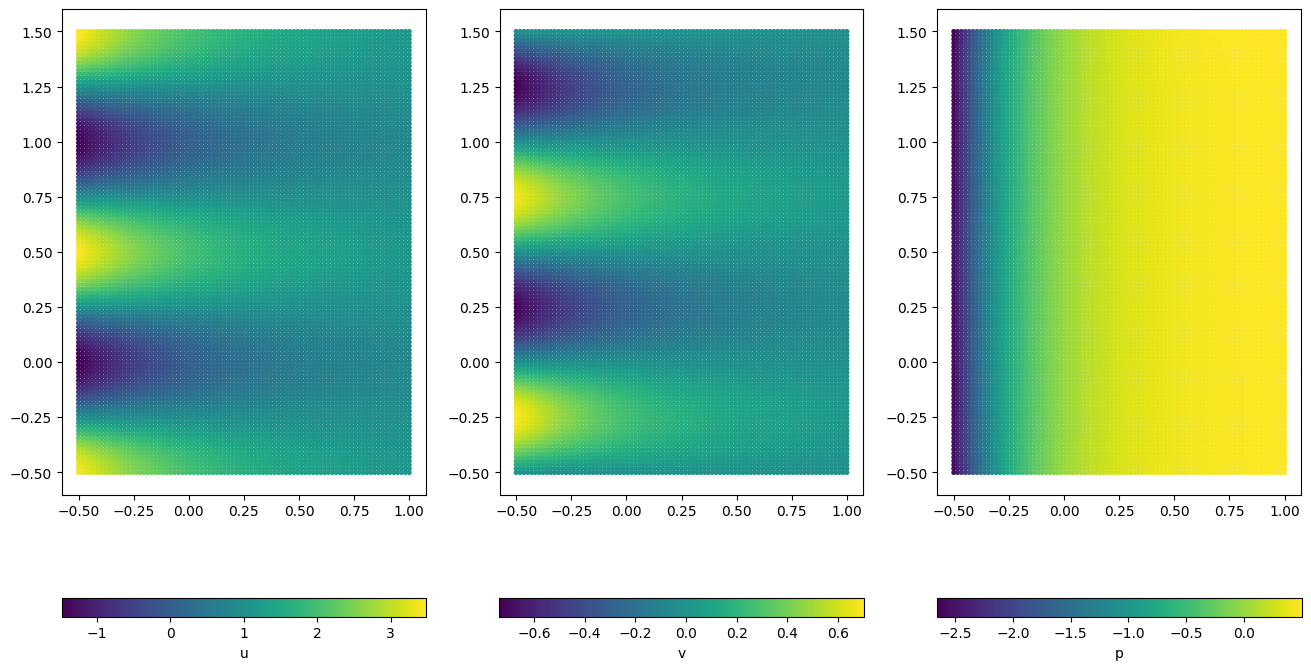

In [20]:
x, pred = dde.plot.scatter_plot(model)